# Project Description & Motivation

Sports have become increasingly more competitive and we have seen athletes and teams invest more in analytics to better improve their performance. This is currently becoming common practice in larger (most team) sports like Football & Basketball however there is great potential to do the same in individual sports such as Squash. Even in Qatar, there is interest from organizations like Aspire Academy, that produces and trains some of the best athletes in the country, to delve deeper into the trends of athletes in various sports. There are 2 benefits of this: firstly, athletes can discover trends and information that will help them perform better; secondly, athletes can statistically see that maybe some of their practices (based on conventional wisdom) may not actually have a positive effect that they think it does. 

Thus, we decided to extract data about male squash players from the official [Professional Squash Association: PSA](https://psaworldtour.com/rankings/world_tour?g=men) website. We scraped the data of their website, formated it into an dataframe/csv format, cleaned & wrangled it, performed EDA to find trends, and make a basic prediction model that predicts the winner of a match given features regarding the 2 competing players

## Table of Content

- [Part 1: Data Collection](#Part-1:-Data-Collection)
- [Part 2: Exploratory Data Analysis](#Part-2:-Exploratory-Data-Analysis)
- [Part 3: Machine Learning Modeling](#Part-3:-Machine-Learning-Modeling)
- [Conclusion](#Conclusion)


### Imports

If you are NOT planning on running the scraping part, as it has a long run time and works better from a python file than a Jupyter Notebook, please only run the following cell of imports. The one after are only the imports needed for web scraping

In [4]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import math
import requests
import csv
import collections
import scipy.stats as stats
import pylab as pl
import time
import selenium
import os
from os import listdir
from tabulate import tabulate

# Import ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Import SKLEARN Metric Functions
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as ms

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Imports for Web Crawling & Scraping

from selenium import webdriver
from bs4 import BeautifulSoup 
from chromedriver_py import binary_path # this will get you the path variable
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

# Part 1: Data Collection

`Note the data collection involves significant web crawling and scraping. This has an incredibly long run time and requires some additional files as well. If you wish to skip to the analysis part on the created dataframe,` [click here](#Begin-Analysis-From-Here)

### 1.1 Web Scraping

#### Task Description

[This](https://psaworldtour.com/rankings/world_tour?g=men&year=2020&month=11) is what the website looks like that shows the ranking of each player for each month in each year (2014-2020)

[This](https://psaworldtour.com/players/view/2028/ali-farag?tab=results) is what the results for each player look like. Note the load more button that Ajaxes the new resutls onto the existing webpage

#### Approach

The following cell extracts the links from the ranking files that are saved in the MHTML pages and saves them in a text file for the relevant year_month combination in the order of the rankings. These files are saved in a folder called `links`

NOTE: For this notebook, we DO NOT provide the MHTML files but provide the `link` folder. DO NOT run the following cell if you are running this notebook from the start

<h3 style='color:#c43916'> IMPORTANT: </h3>

The following code (web crawling and scraping) has an extremely long run time of almost a several hours. It also requires some additional files to be downloaded and stores in a certain directory. This code was not run on this Jupyter Notebook but was run using a locally installed version of Python on a Windows Machine. In the submission folder there is a `SCRAPING INSTRUCTIONS.txt` file that explains the process, the additional files needed, and the steps to perform the scraping. PLEASE DO NOT RUN THIS CODE WITHOUT THOSE STEPS

In [ ]:
### MAKING LINK FILES
years_array = ["2014", "2015", "2016", "2017", "2018", "2019","2020"]
months_array = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]

for year in years_array:
    for month in months_array:
        if year != "2020" and month != "december":
            open_file_name = year + "_" + month + "_rankings.mhtml"
            close_file_name = "/links/" + year + "_" + month + "_player_links.txt" 
            f = open(open_file_name,"r")
            j = open(close_file_name,"w")
            text = f.readlines()
            pattern = 'href=3D'
            the_links = []
            starter = False
            for line in text:
                if line.find('<div class=3D"rankings rankings--men') != -1:
                    starter = True
                if line.find(pattern) != -1 and starter == True:
                    the_links.append(line)
                if line.find('class=3D"rankings__index text--center">200') != -1:
                    starter= False
            count = 0
            for link in the_links:
                if count == 0 and year != "2014" and year != "2015":
                    print(link)
                    link = link[0:len(link)-2] + '">' + "\n"
                    count= count+1
                start = link.find('href=3D"')
                end = link.find(">")
                link = link[start+8:end-1]
                j.write(link + "\n")
            f.close()
            j.close()

The following cell makes unqiue links for all the players and saves them in a text file named `unique_links.txt` so that we can scrape the data about matches for each player. We take unqiue links because each player appears several times in the rankings for each month_year and we want to avoid redundant scraping as the information regarding the matches for each player is provided on one page (their profile page).

In [ ]:
### MAKING UNIQUE LINKS
final = []
for file_name in (os.listdir("./links")):
    temp_f = open("./links/" + file_name, "r")
    t = temp_f.readlines()
    final = final + t
    temp_f.close()

final_u = list(set(final))
f = open("unique_links.txt", "w")
for line in final_u:
    if (line[0] == "/"):
        f.write(line)
f.close()

The function `extracting_page_source` takes a player's profile page link (provided from `unique_links.txt` made by the previous cell) and uses Selenium to scape all the results from their page. The page uses Ajaxing to display results through a LOAD MORE button which the crawler clicks until all the results are displayed (the LOAD MORE button goes away) and then saves the HTML of that page in a folder called `Final Page Sources`

In [ ]:
def extracting_page_source(the_link):
        start = time.time() 
        the_link_split = the_link.split("/")
        file_name = the_link_split[-1]
        file_name = file_name.replace("\n", "")
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--incognito')
        options.add_argument('--headless')
        driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        
        driver.get("https://psaworldtour.com" + str(the_link))

        time.sleep(7)
        cookies_repeat = False
        info_repeat = False
        results_repeat = False
        load_repeat = False
        broken_page = False

        #### THE COOKIES BUTTON PATH
        try:
                cookies_button = driver.find_element_by_xpath("//div[@id='adroll_allow']")
        except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                cookies_repeat = True

        if (cookies_repeat == True):
                driver.refresh()
                time.sleep(2)

        try:
                cookies_button = driver.find_element_by_xpath("//div[@id='adroll_allow']")
        except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                print("NO COOKIES")
        

        #### THE INFO BUTTON PATH
        try:
                info_button = driver.find_element_by_xpath("//div[@data-tab='info']")
        except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                info_repeat = True

        if (info_repeat == True):
                driver.refresh()
                time.sleep(1.5)
                try:
                        info_button = driver.find_element_by_xpath("//div[@data-tab='info']")
                        
                except (selenium.common.exceptions.NoSuchElementException,
                            selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                        broken_page = True

        if (broken_page == True):
                t_f = open("broken_links.txt", "a")
                t_f.write(the_link + "\n")
                t_f.close()
                driver.quit()
                return None

        #### THE RESULTS BUTTON PATH
        try:
                results_button = driver.find_element_by_xpath("//div[@data-tab='results']")
        except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                results_repeat = True

        if (results_repeat == True):
                driver.refresh()
                time.sleep(1.5)
                try:
                        results_button = driver.find_element_by_xpath("//div[@data-tab='results']")
                        
                except (selenium.common.exceptions.NoSuchElementException,
                            selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                        broken_page = True

        
        if (broken_page == True):
                t_f = open("broken_links.txt", "a")
                t_f.write(the_link + "\n")
                t_f.close()
                driver.quit()
                return None

                          
        #### THE LOAD BUTTON PATH
        try:
                load_button = driver.find_element_by_xpath("//div[@class='btn--gender btn--neutral btn--centered btn--wide js-load-more']")
        except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                load_repeat = True

        if (load_repeat == True):
                driver.refresh()
                time.sleep(1.5)
                try:
                        load_button = driver.find_element_by_xpath("//div[@class='btn--gender btn--neutral btn--centered btn--wide js-load-more']")
                        
                except (selenium.common.exceptions.NoSuchElementException,
                            selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                        broken_page = True

        if (broken_page == True):
                t_f = open("broken_links.txt", "a")
                t_f.write(the_link + "\n")
                t_f.close()
                driver.quit()
                return None
        

        time.sleep(2)
        
        cookies_button.click()

        results_button.click()

        info_button.click()

        results_button.click()

        for i in range(27):
            try:
                load_button = driver.find_element_by_xpath("//div[@class='btn--gender btn--neutral btn--centered btn--wide js-load-more']")
                load_button.click()
                time.sleep(1.5)

            except (selenium.common.exceptions.NoSuchElementException,
                    selenium.common.exceptions.ElementClickInterceptedException,
                                selenium.common.exceptions.WebDriverException):
                    continue

        file_name = file_name.replace('"', '')
        f1 = open(str(file_name) + "_source.txt","w", encoding="utf-8")
        page_source = driver.page_source
        driver.close()

        start1 = time.time()
        try:
                soup = BeautifulSoup(page_source, 'lxml')
                page_source1 = soup.prettify()
                f1.write(str(page_source1))

        except (UnicodeEncodeError):
                f1.close()
                os.remove(str(file_name) + "_source.txt")
                f1 = open(str(file_name) + "_source.txt","w", encoding = "utf-8")
                soup = BeautifulSoup(page_source, 'lxml')
                page_source2 = soup.prettify()
                f1.write(str(page_source2))
        f1.close()

        f2 = open(str(file_name) +"_source.txt","r", encoding="utf-8")
        f3 = open("./Final Page Sources/" + str(file_name) + ".txt", "w")
        file_2_text_org = f2.readlines()
        starter = False
        for line in file_2_text_org:
                #print(line)
                if 'player__stats' in line:
                        starter = True
                if starter == True:
                        try:
                                f3.write(line)
                        except (UnicodeEncodeError):
                                print("UNICODE ERROR")

        f2.close()
        f3.close()
        os.remove(str(file_name) +"_source.txt")
        end = time.time()
        print("Done With File: " + str(file_name))
        driver.quit()


The function `result_parser` takes a saved HTML file from the previous function (from the folder `Final Page Sources` and parses the results and saves it into a datastructure of our own design. This data structure has the following schema:

all_results_for_one_player = {

torn_name : {

torn_date: "",

torn_class:"",

torn_results: [

            {
            
            round_name = "",
            
            opponent_name = "",
            
            win_loss = "",
            
            wr = "",
            
            game_score = "",
            
            scores = []
            
            }
            
        ]   
     }
}

In [ ]:
def result_parser(file_name):
    start = time.time()
    name = ""
    dob = ""
    height = ""
    weight = ""

    round_names_list = [
        "Round 1",
        "Round 2",
        "Round 3",
        "Round 4",
        "Round 5",
        "Round 6",
        "Round 7",
        "Round 8",
        "Quarter final",
        "Semi final",
        "Final"
    ]
    ### Tournament Starter: h--asher-box h--margins
    all_results = {}
    
    ### Last Tournament Ender: btn--gender btn--neutral btn--centered btn--wide js-load-more is-hidden
    torn_starter = False
    f1 = open(file_name, "r")
    file_2_text_without_header = f1.readlines()
    
    torn_starter = False
    score_starter = False
    round_starter = False
    round_scores_starter = False
    torn_name_t = ""
    torn_date_t = ""
    torn_class_t = ""
    round_name_t = ""
    opponent_name_t = ""
    wr_t = ""
    game_score_t = ""
    win_loss_t = ""
    win_loss_t = ""
    scores_t = ""
    counter = 0
    for i in range(len(file_2_text_without_header)):

            ### For Name
        if file_2_text_without_header[i].find("th colspan") != -1:
            
            name = file_2_text_without_header[i+1].strip()

            ### For DOB
        elif file_2_text_without_header[i].find("Date of Birth")  != -1:
            
            dob = file_2_text_without_header[i+3].strip()

            ### For Height
        elif file_2_text_without_header[i].find("Height (cm)") != -1:
            
            height = file_2_text_without_header[i+3].strip()

            ### For Weight
        elif file_2_text_without_header[i].find("Weight (kg)") != -1:
            
            weight = file_2_text_without_header[i+3].strip()

        ###### For Results
        elif file_2_text_without_header[i].find("h--asher-box h--margins") != -1 and (torn_starter == False):
            torn_starter = True
            torn_name_t = file_2_text_without_header[i+1]
        
        elif file_2_text_without_header[i].find("right text--white") != -1 and torn_starter:
            
            torn_date_t = file_2_text_without_header[i+1]

        elif file_2_text_without_header[i].find('class="right"')!= -1 and torn_starter:
            
            torn_class_t = file_2_text_without_header[i+1]
       	    
        elif file_2_text_without_header[i].find('Scores') != -1 and torn_starter:
              
            torn_results_t = []
            score_starter = True

        elif (file_2_text_without_header[i].strip() in round_names_list) and score_starter:
            
            round_starter = True
            round_name_t = file_2_text_without_header[i]
            opponent_name_t = file_2_text_without_header[i+3]

        elif file_2_text_without_header[i].find('text--center') != -1 and round_starter:
            if file_2_text_without_header[i+1].strip().isdigit():
                
                wr_t = file_2_text_without_header[i+1]

        elif (file_2_text_without_header[i].find('text--grass') != -1 or file_2_text_without_header[i].find('text--ruby') != -1) and round_starter:
            
            game_score_t = file_2_text_without_header[i+1]
            if file_2_text_without_header[i].find('text--grass') != -1:
                
                win_loss_t = "Win"
            elif file_2_text_without_header[i].find('text--ruby') != -1:
                
                win_loss_t = "Loss"

        elif file_2_text_without_header[i].find('ul--horizontal') != -1 and round_starter:
            
            round_scores_starter = True
            scores_t = [file_2_text_without_header[i+2].strip()]

        elif file_2_text_without_header[i].strip() == "<li>" and round_scores_starter:
            
            scores_t.append(file_2_text_without_header[i+1].strip())

        elif file_2_text_without_header[i].strip() == "</ul>" and round_scores_starter:
            
            round_scores_starter = False
            round_starter = False
            scores_t = scores_t[1:]
            torn_results_t.append(
                            {
              "round_name" : round_name_t.strip(),
              "opponent_name" : opponent_name_t.strip(),
              "win_loss" : win_loss_t.strip(),
              "wr" : wr_t.strip(),
              "game_score" : game_score_t.strip(),
              "scores" : scores_t
                            }
                    )
            
        elif file_2_text_without_header[i].find('class="result"') != -1 and score_starter:
            
            score_starter = False
            torn_starter = False
            torn_name_t = torn_name_t.strip()
            all_results[torn_name_t] = {
                    torn_name_t : {
                            "torn_date" : torn_date_t.strip(),
                            "torn_class" : torn_class_t.strip(),
                            "torn_results" : torn_results_t
                    }
            }

        elif (file_2_text_without_header[i].find('btn--gender btn--neutral btn--centered btn--wide js-load-more is-hidden') != -1 or file_2_text_without_header[i].find('Load More') != -1):

            break

    end = time.time()
    return all_results, name, dob, height, weight


The function `group_soruce_extractor` calls source extractor and saves the HTML code for all the players in the `unique_links.txt` file

In [ ]:
def group_soruce_extractor():
    links_file = open("unique_links.txt", "r")
    links_array = links_file.readlines()
    for i in range(len(links_array)):
        if links_array[i] != "" and links_array[i] != " ":
            extracting_page_source(str(links_array[i]))

In [ ]:
# group_soruce_extractor()

The following cell parses the results for ALL of the saved HTML files for each player

In [ ]:
saaray_results = {}
for source_file in os.listdir("./Final Page Sources"):
    temp_results, temp_name, temp_dob, temp_height, temp_weight = result_parser("./Final Page Sources/" + source_file)
    temp_name = temp_name.replace("Profile", "")
    saaray_results[str(source_file.replace(".txt", ""))] = [temp_results, temp_name, temp_dob, temp_height, temp_weight]


Helper function to convert dictionary values into a dataframe (or add to an existing global df)

In [ ]:
def dict_to_df(torn_dict, name, dob, torn_name ,rank, year, month):
    global df
    df_cols = ["Year", "Month", "Rank", "Name", "DOB", "Tournament", "Torn_Class" ,"Round", "Opponent", "Game_Number", "Score", "Win_Loss"]
    torni_class = torn_dict['torn_class']
    for result in torn_dict["torn_results"]:
        round_name = result['round_name']
        opponent_name = result['opponent_name']
        score = result['game_score']
        win_loss = result['win_loss']
        count = 0
        for score in result['scores']:
            the_score = score 
            count = count + 1
            temp = pd.Series([year, month, rank, name, dob, torn_name, torni_class, round_name, opponent_name, count, (" "+the_score), win_loss], index = df_cols)
            df = df.append(temp ,ignore_index=True)
    return 


We then take all the saved information from our data structures for each player and add it into a dataframe

In [ ]:
months_org = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october",
    "november", "december"]
month_vals = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df_cols = ["Year", "Month", "Rank", "Name", "DOB", "Tournament", "Torn_Class" ,"Round", "Opponent", "Game_Number", "Score", "Win_Loss"]
df = pd.DataFrame(columns=df_cols)
for file in os.listdir("./links"):    
    f = open("./links/" +file, "r")
    links = f.readlines()
    print(file)
    the_year = file.split("_")[0]
    the_month = file.split("_")[1]
    month_compare_val = month_vals[(months_org.index(the_month) - 1)]
    if (month_compare_val == "Dec"):
        the_year_compare = str(int(the_year)-1)
    else:
        the_year_compare = the_year
    
    for i in range(len(links)):
        if (links[i].split("/")[-1].replace("\n", "").replace('"', "") in list(saaray_results.keys())):
            link_values = saaray_results[links[i].split("/")[-1].replace("\n", "").replace('"', "")]
            name, dob, height, weight = link_values[1], link_values[2], link_values[3], link_values[4]
            results_dict = link_values[0]
            for key in results_dict.keys():
                # Get Torn Date
                the_date = results_dict[key][key]["torn_date"]
                if (str(key).find(str(the_year_compare)) != -1 and the_date.find(month_compare_val) != -1):
                    dict_to_df(results_dict[key][key], name, dob, str(key), (i+1), the_year, the_month)
    f.close()      
print("DONE")

We then add the age_then column to the data using the player's date of birth and the current year

In [ ]:
df2 = df
df2 = df2.astype({'Year': 'object'})
df2 = df2.assign(dob_year = df2.DOB[-4:])

dob_list = df2.DOB.tolist()
for i in range(len(dob_list)):
    dob_list[i] = dob_list[i].split()[-1]

year_list = df2.Year.tolist()

age_then = []
for j in range(len(dob_list)):
    age_then.append(int(year_list[j]) - int(dob_list[j]))
    
data = np.array(age_then) 
  
age_then_series = pd.Series(np.array(age_then)) 

df2 = df2.assign(Age_Then = age_then_series)

### The Format of the Resulting DF:

1. Year : Year the tournament that tournament was played (in which the game was played)
2. Month : Month of that year the tournament that tournament was played (in which the game was played)
3. Rank : Ranking of that player IN THAT month of that year
4. Name : Name of Player whose information is in that row (who played the game)
5. DOB : Date of Birth of that player
6. Tournament : Name of the tournament in which that game was played
7. Torn_Class : Class Ranking (given to tournaments) of that tournament
8. Round : Round in which that game was played (Semi Final, Final, etc)
9. Opponent : Name of opponent in that game
10. Game Number : The game number of the game of that match that is represented in that row
11. Score : Score of the game itself
12. Win_Loss: IMPORTANT - Shows win/loss result of the entire match (NOT THAT GAME) from the perspective of the player mentioned in the Name column of that row
13. Age_Then : Age of the player mentioned in the Name column WHEN THAT GAME WAS PLAYED

Saving Dataframe to CSV because the scraping code has a very long runtime

In [ ]:
# df2.to_csv('squash_rankings_till_sept_2020.csv', index=False)

### End Of Web Scraping Section

## Begin Analysis From Here 

Loading Data

In [41]:
file = "squash_rankings_till_sept_2020.csv"
data = pd.read_csv(file, header = 0) 
data.head()

,Year,Month,Rank,Name,DOB,Tournament,Torn_Class,Round,Opponent,Game_Number,Score,Win_Loss,Age_Then
0,2014,april,1,Gregory Gaultier,"23rd December, 1982",METROsquash Windy City Open 2014,World Series Gold Event,Final,R. Ashour,1,11-7,Win,32
1,2014,april,1,Gregory Gaultier,"23rd December, 1982",METROsquash Windy City Open 2014,World Series Gold Event,Final,R. Ashour,2,11-3,Win,32
2,2014,april,1,Gregory Gaultier,"23rd December, 1982",METROsquash Windy City Open 2014,World Series Gold Event,Final,R. Ashour,3,11-4,Win,32
3,2014,april,1,Gregory Gaultier,"23rd December, 1982",METROsquash Windy City Open 2014,World Series Gold Event,Semi final,M. ElShorbagy,1,11-7,Win,32
4,2014,april,1,Gregory Gaultier,"23rd December, 1982",METROsquash Windy City Open 2014,World Series Gold Event,Semi final,M. ElShorbagy,2,6-11,Win,32


## Part 2: Exploratory Data Analysis

Now that we have scraped our dataset from the web, we are ready to conduct preliminary data analysis. This analysis will help us understand more about the data we are working with, to summarize some initial results, and to understand where we should investigate and model further.

### We'll analyze the following parts of our dataset in this section:

- [Seasonality of Matches](#Seasonality-of-Matches)
- [Scores](#Scores)
- [Player Age](#Player-Age)
- [The best player in the world: Mohamed El Shorbagy](#The-best-player-in-the-world:-Mohamed-El-Shorbagy)
- [The second best player in the world: Ali Farag](#The-second-best-player-in-the-world:-Ali-Farag)

## Setting a theme

We'll set a consistent theme to make our Seaborn visualizations consistent clear.

In [42]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")

## Seasonality of Matches

Squash is mostly played indoors so tournaments can occur at all times of the year. With that being said, being a professional athlete is a grueling career and everyone needs a break. Let's see how games vary by month across the years of our dataset. 

In [ ]:
order = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]

fig = sns.countplot(data = data, order=order, x="Month", color = "darkblue")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set(title = "Matches by Month For All Years", xlabel="Months", ylabel="Number of Games")
sns.despine(left=True, bottom=True)

The total number of games each year should give us an idea of if Squash is becoming more or less popular. 
<br><br>
It seems to rise every year (with the exception of 2016-2017) but oof - 2020 was rough. It's hard to socially distance on a Squash court :(

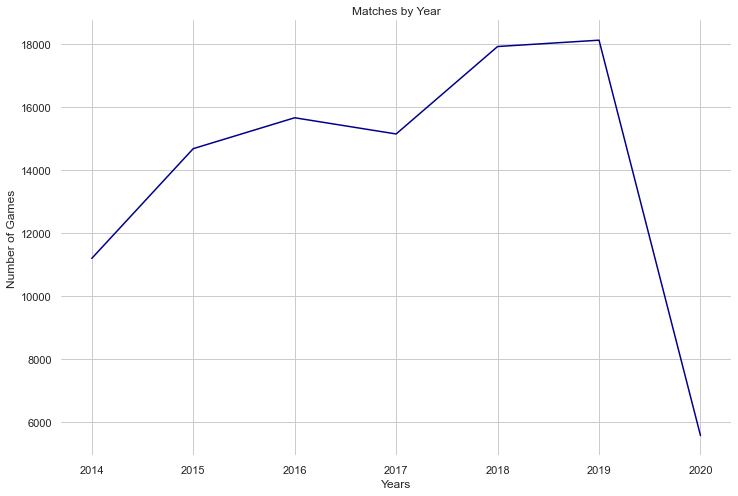

In [44]:
years = data["Year"].value_counts().index.tolist()
counts = data["Year"].value_counts().values

fig = sns.lineplot(x = years, y = counts, color = "darkblue")
fig.set(title = "Matches by Year", xlabel="Years", ylabel="Number of Games")
sns.despine(left=True, bottom=True)

## Scores

In Squash, the first player to get 11 points in a game wins -- as long as they have two more points then their opponent. 
<br><br>
The more total points in a game, the closer the game. Let's see how many games were close and how many games were blowouts.

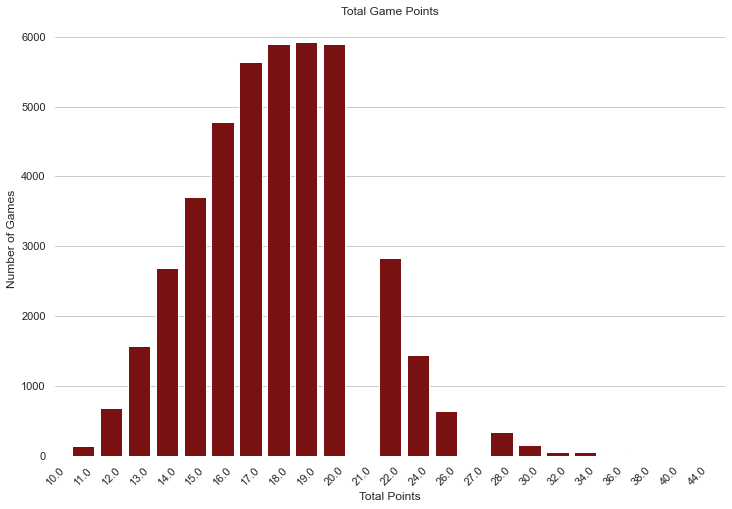

In [49]:
# data manipulation

data[['score1','score2']] = data["Score"].str.split("-",expand=True) 

data["score1"] = pd.to_numeric(data["score1"], errors='coerce')
data["score2"] = pd.to_numeric(data["score2"], errors='coerce')

data["totalScore"] = data["score1"] + data["score2"]

## each game has two points of view so we need to cut the dataset in half -- otherwise everything will be doubled

losses = data[data["Win_Loss"] == "Loss"]

# graph

fig = sns.countplot(data = losses, x="totalScore", color = "darkred")
fig.set(xlim=(10,36))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set(title = "Total Game Points", xlabel="Total Points", ylabel="Number of Games", xlim=(10, 34))

sns.despine(left=True, bottom=True)


## Player Age

Many sports like gymnastics, American football, and ice hockey are a young person's game since the sport is so physically demanding. Others like football (soccer), baseball, and golf have many players who are able to continue playing and even improve as they get older.
<br><br>
Let's see if Squash is a game where older players' skills can keep their careers going or if the best rail shots are hit by young people. 

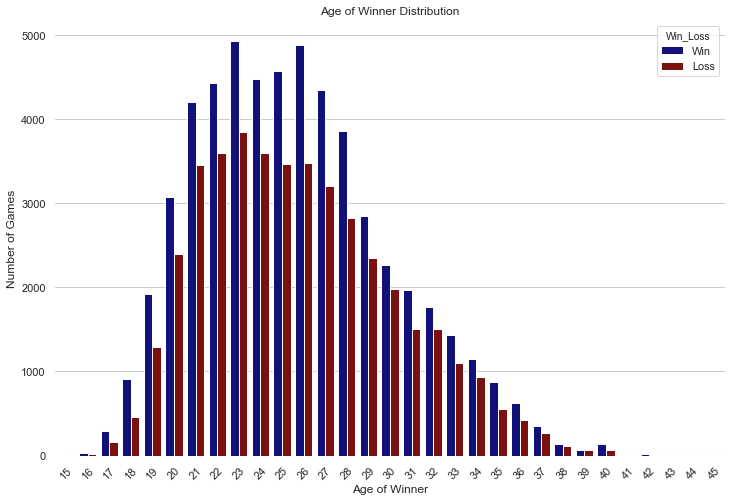

In [50]:
# age of winners histogram

# data maniputlation 

wins = data[data["Win_Loss"] == "Win"]

# plot

fig = sns.countplot(data = data, x="Age_Then", hue = "Win_Loss", alpha=1, palette = ["darkblue", "darkred"])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.set(title = "Age of Winner Distribution", xlabel="Age of Winner", ylabel="Number of Games")

sns.despine(left=True, bottom=True)

## The best Squash player in the world: `Mohamed El Shorbagy`

[<img src="https://psaworldtour.com/uploads/crop_image/1060/530/20191110173838_Mo-ElShorbagy-Worlds-RD2.jpg?x=0&y=-170.78125&w=1069&o=1060&">]

Egyptian Mohamed El Shorbagy is 29 years old and the best Squash player in the world. Shorbagy first ranked number one in 2014 when we have 23 but has managed to climb his way back up the rankings to win the Machester Open in September 2020. Let's take a look at his record.

Shorbaggy has been playing Squash professionally since age 15 (2006). Let's see how many games he's won and lost in the last six years.

[21, 19, 18, 17, 17, 17, 14, 14, 13, 13, 13, 10, 10, 8, 5, 5, 5, 4, 4, 3, 3, 3, 2, 2]


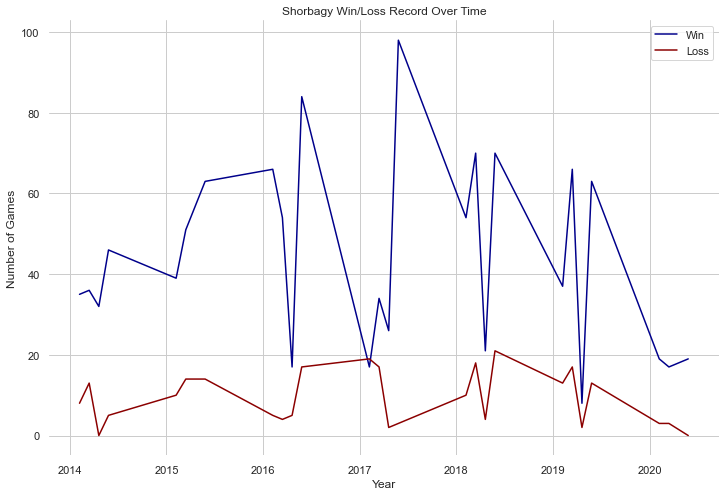

In [52]:
# data manipulation

d = {"january":1, "february":1, "march":1, "april":2, "may":2, "june":2, "july":3, "august":3, "september":3, "october":4, "november":4, "december":4}

data["MonthNum"] = data["Month"].map(d)

data["year_month"] = data["Year"] + data["MonthNum"] / 10

shorbagy = data[data["Name"] == "Mohamed ElShorbagy "]

shorbagyWins = shorbagy[shorbagy["Win_Loss"] == "Win"]
shorbagyLosses = shorbagy[shorbagy["Win_Loss"] == "Loss"]

yearWinsShorbagy = shorbagyWins["year_month"].value_counts().index.tolist()
countWinsShorbagy = shorbagyWins["year_month"].value_counts().values
countWinsShorbagy = countWinsShorbagy.tolist()

yearLossesShorbagy = shorbagyLosses["year_month"].value_counts().index.tolist()
countLossesShorbagy = shorbagyLosses["year_month"].value_counts().values
countLossesShorbagy = countLossesShorbagy.tolist()

# Shorbagy lost no matches these quarters so they didn't show up on .value_counts() so we'll need to add the data back
yearLossesShorbagy.append(2014.3)
yearLossesShorbagy.append(2020.4)

print(countLossesShorbagy)

countLossesShorbagy.append(0)
countLossesShorbagy.append(0)

fig = sns.lineplot(data= data, x = yearWinsShorbagy, y = countWinsShorbagy, color = "darkblue", legend='brief', label="Win")
fig = sns.lineplot(x = yearLossesShorbagy, y = countLossesShorbagy, color = "darkred", legend='brief', label="Loss")
fig.set(title = "Shorbagy Win/Loss Record Over Time")
fig.set(xlabel="Year", ylabel="Number of Games")
sns.despine(left=True, bottom=True)


There's a lot of variation in how many games Shorbagy plays. Let's see how his win percent has changed over time.

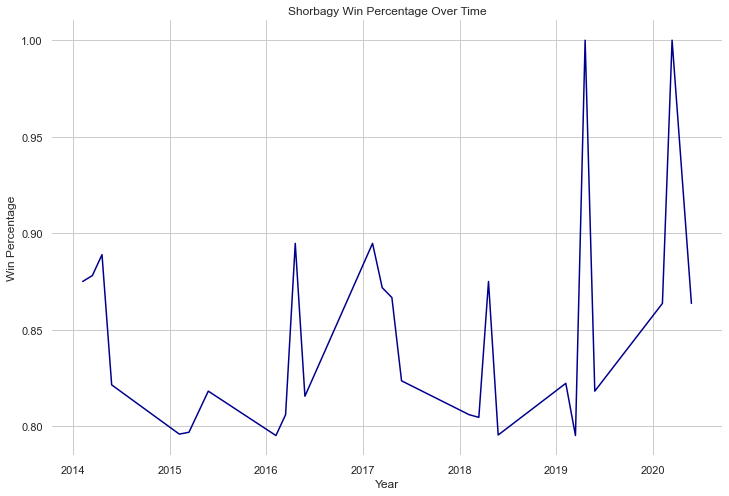

In [54]:
totalsShorbagy = [int(a) + int(b) for a, b in zip(countWinsShorbagy, countLossesShorbagy)]

winPercentShorbagy = [int(c) / int(d) for c, d in zip(countWinsShorbagy, totalsShorbagy)]

fig = sns.lineplot(x = yearWinsShorbagy, y = winPercentShorbagy, color = "darkblue")
fig.set(title = "Shorbagy Win Percentage Over Time")
fig.set(xlabel="Year", ylabel="Win Percentage")
sns.despine(left=True, bottom=True)

Shorbagy's win percent has decreased over time. Maybe that's because he's getting older but it's probably moreso because he's playing more competative matches. Since matches can have up to five games, Shorbagy could win a match but only have a game win percent of 60%.

And let's see how Shorbagy has ranked over the last six years.

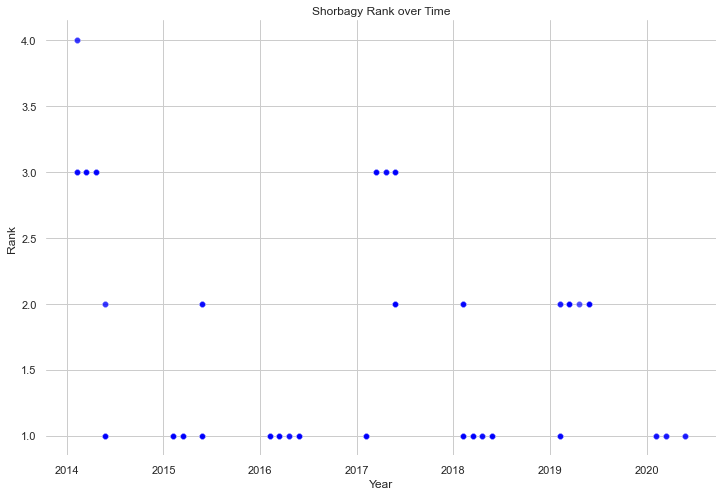

In [57]:
fig = sns.scatterplot(data = shorbagy, x = "year_month", y="Rank", color = "blue", alpha=0.1)
fig.set(title = "Shorbagy Rank over Time", xlabel="Year", ylabel="Rank")
sns.despine(left=True, bottom=True)

## The second best player in the world: `Ali Farag`

[<img src="http://cairogossip.com/app/uploads/2019/03/ali.jpg">]

Also Egyptian, 28 year old Ali Farag is the second best Squash player in the world. Farag battled his way to number one in the past two years and has traded places with Mohamed El Shorbagy ever since. 

Let's take see how Farag has done in the last six years.

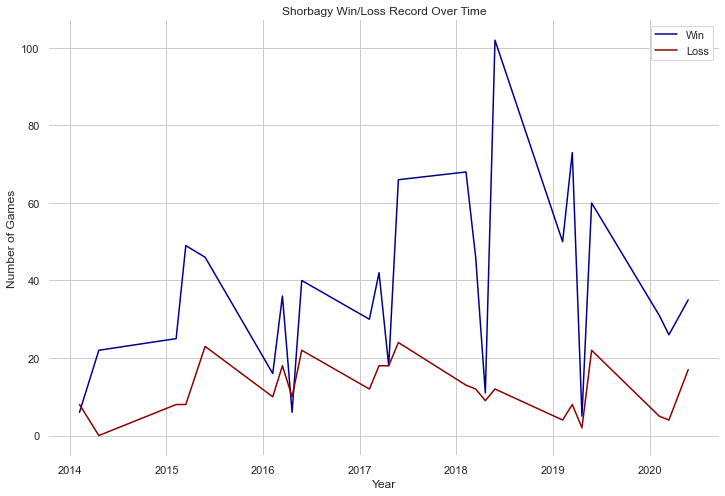

In [59]:
# data manipulation

farg = data[data["Name"] == "Ali Farag "]

fargWins = farg[farg["Win_Loss"] == "Win"]
fargLosses = farg[farg["Win_Loss"] == "Loss"]

yearWinsFarg = fargWins["year_month"].value_counts().index.tolist()
countWinsFarg = fargWins["year_month"].value_counts().values
countWinsFarg = countWinsFarg.tolist()

yearLossesFarg = fargLosses["year_month"].value_counts().index.tolist()
countLossesFarg = fargLosses["year_month"].value_counts().values
countLossesFarg = countLossesFarg.tolist()

# Farg lost no matches this quarter so they didn't show up on .value_counts() and we'll need to add the data back
yearLossesFarg.append(2014.3)

countLossesFarg.append(0)

fig = sns.lineplot(x = yearWinsFarg, y = countWinsFarg, color = "darkblue",legend='brief', label="Win")
fig = sns.lineplot(x = yearLossesFarg, y = countLossesFarg, color = "darkred",legend='brief', label="Loss")
fig.set(title = "Shorbagy Win/Loss Record Over Time")
fig.set(xlabel="Year", ylabel="Number of Games")
sns.despine(left=True, bottom=True)

It looks like Farag's wins have been the highest in mid-2018, second highest in early 2019, and third highest in early 2018.

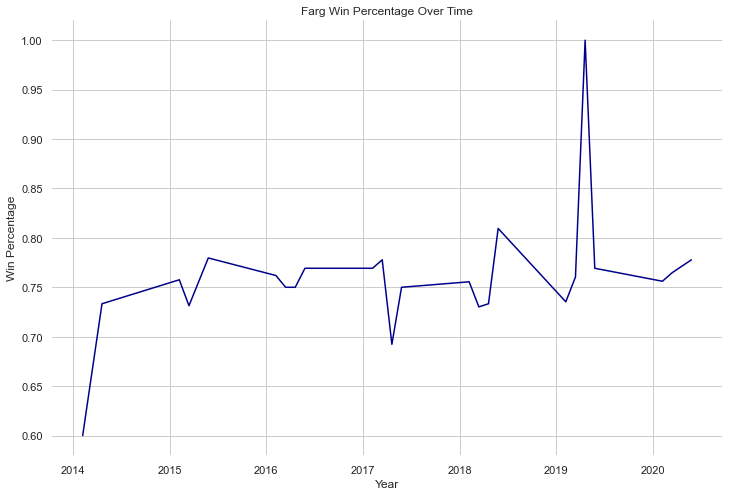

In [61]:
totalsFarg = [int(a) + int(b) for a, b in zip(countWinsFarg, countLossesFarg)]

winPercentFarg = [int(c) / int(d) for c, d in zip(countWinsFarg, totalsFarg)]

fig = sns.lineplot(x = yearWinsFarg, y = winPercentFarg, color = "darkblue")
fig.set(title = "Farg Win Percentage Over Time")
fig.set(xlabel="Year", ylabel="Win Percentage")
sns.despine(left=True, bottom=True)

And how about his rank. Is Farag as consistent as Shorbagy?

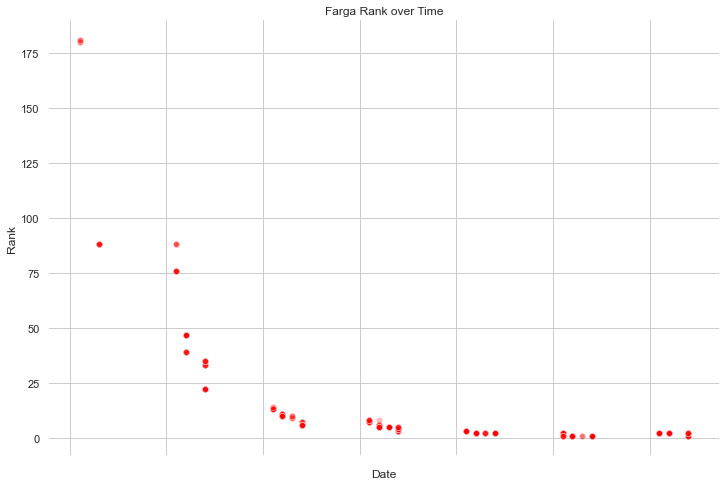

In [62]:
# rank over time

fig = sns.scatterplot(data = farg, x = "year_month", y="Rank", color = "red",  alpha=0.1)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set(title = "Farga Rank over Time", xlabel="Date", ylabel="Rank")

sns.despine(left=True, bottom=True)

It seems his rank has been more inconsistent when compared to Shorbagy's, and he's had more of a struggle making it to the top, but has consistently remained there after a certain point.

## Comparing `Ali Farag` and `Mohamed El Shorbagy`

[<img src="https://psaworldtour.com/uploads/crop_image/1060/597/S3CZd1UZ1d3CK0Njc.png?">]

Both being from Egypt and about the same age, it's natural to compare Farag and Shorbagy. Let's compare their records side by side.

## Average Game Scores


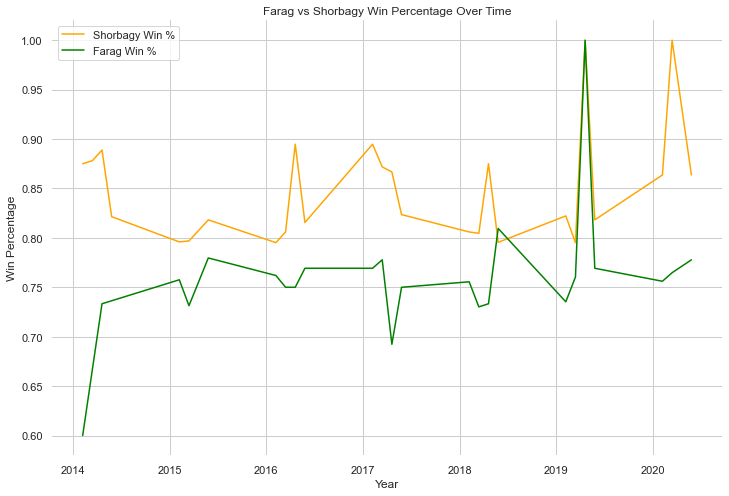

In [64]:
fig = sns.lineplot(x = yearWinsShorbagy, y = winPercentShorbagy, color = "orange", legend='brief', label="Shorbagy Win %")
fig = sns.lineplot(x = yearWinsFarg, y = winPercentFarg, color = "green",legend='brief', label="Farag Win %")
fig.set(title = "Farag vs Shorbagy Win Percentage Over Time")
fig.set(xlabel="Year", ylabel="Win Percentage")
sns.despine(left=True, bottom=True)
sns.despine(left=True, bottom=True)

From the graph above it looks like Shorbagy's win percentage has generally remained higher than Farag's. Although there was some close competition in 2019!

### Who's better beyond game 5? 

The first person to win three games in a Squash match wins! That makes the fifth game of a march the closest and most important game. Let's see if one of our players is better at taking home victory at such a crucial time.

Shorbagy Win % Above 5 Games:
0.61


Farg Win % Above 5 Games:
0.65


[Text(0, 0.5, 'Number of Games'),
 Text(0.5, 0, 'Win/Loss'),
 Text(0.5, 1.0, 'Farag vs. Shorbagy Record in Game 5')]

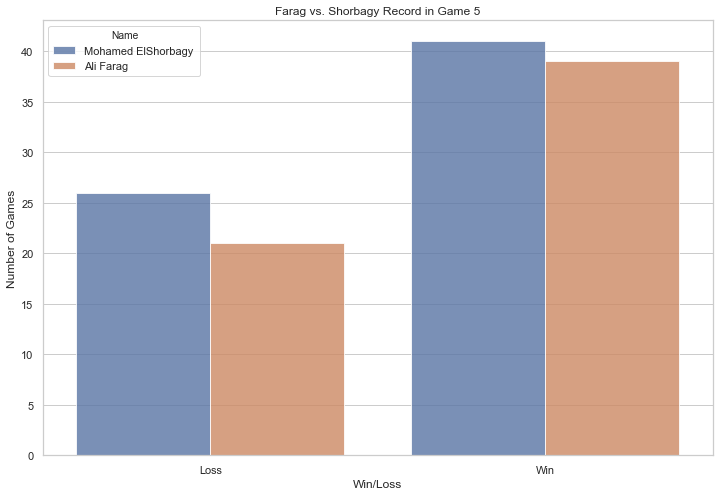

In [65]:
shorbagyabove5 = shorbagy[shorbagy["Game_Number"] >= 5]

fargabove5 = farg[farg["Game_Number"] >= 5]

above5 = shorbagyabove5.append(fargabove5)


shorbagyPercent = round(shorbagyabove5["Win_Loss"].value_counts()[0] / len(shorbagyabove5),2)
print("Shorbagy Win % Above 5 Games:")
print(shorbagyPercent)

print("\n")

fargPercent = fargabove5["Win_Loss"].value_counts()[0] / len(fargabove5)
print("Farg Win % Above 5 Games:")
print(fargPercent)

fig = sns.countplot(data = above5, x = "Win_Loss", hue = "Name", alpha=0.8)
fig.set_xticklabels(fig.get_xticklabels(), rotation=0)
fig.set(title = "Farag vs. Shorbagy Record in Game 5", xlabel="Win/Loss", ylabel="Number of Games")


Surprisingly, from the results above, it looks like Farg's win percentage is slightly higher than Shorbagy's beyond game 5! This tells us a little bit about how Farag handles high pressure games better than Shorbagy, an interesting find!

## Lets compare a top ranking player like `Mohamed El Shorbagy` with a low ranking player like `Tristan Eysele `

## Introducing `Tristan Eysele`

[<img src="https://psaworldtour.com/uploads/crop_image/511/396/20170502150234_Mohamed%20ElSherbini.png?x=-16&y=-28&w=1239&o=1060&=undefined">]

Tristan is a 30 year old South African Squash player and while impressive, peaked at ranking 126.
<br><br>
Let's take a look at Tristan's record and how he compares to our champions.

Tristan's win/loss record over time:

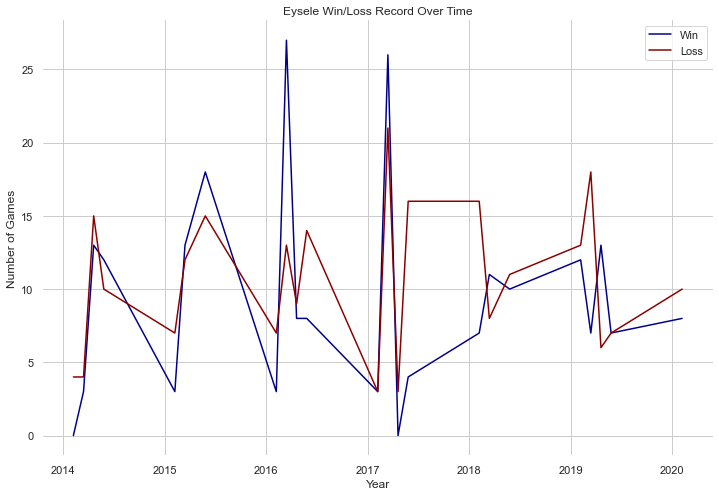

In [69]:
data["Rank"].max()
data.loc[data["Rank"] == data["Rank"].max(), 'Name']

# data manipulation

eysele = data[data["Name"] == "Tristan Eysele "]

eyseleWins = eysele[eysele["Win_Loss"] == "Win"]
eyseleLosses = eysele[eysele["Win_Loss"] == "Loss"]

yearWinsEysele = eyseleWins["year_month"].value_counts().index.tolist()
countWinsEysele = eyseleWins["year_month"].value_counts().values
countWinsEysele = countWinsEysele.tolist()

yearLossesEysele = eyseleLosses["year_month"].value_counts().index.tolist()
countLossesEysele = eyseleLosses["year_month"].value_counts().values
countLossesEysele = countLossesEysele.tolist()

# Farg won no matches this quarter so they didn't show up on .value_counts() and we'll need to add the data back
yearWinsEysele.append(2014.1)
yearWinsEysele.append(2017.3)

countWinsEysele.append(0)
countWinsEysele.append(0)

fig = sns.lineplot(x = yearWinsEysele, y = countWinsEysele, color = "darkblue", legend='brief', label="Win")
fig = sns.lineplot(x = yearLossesEysele, y = countLossesEysele, color = "darkred", legend='brief', label="Loss")
fig.set(title = "Eysele Win/Loss Record Over Time", xlabel="Year", ylabel="Number of Games")

sns.despine(left=True, bottom=True)

Which looks like he had the most wins in early 2016 and 2017, and the highest amount of losses in early 2017 as well.

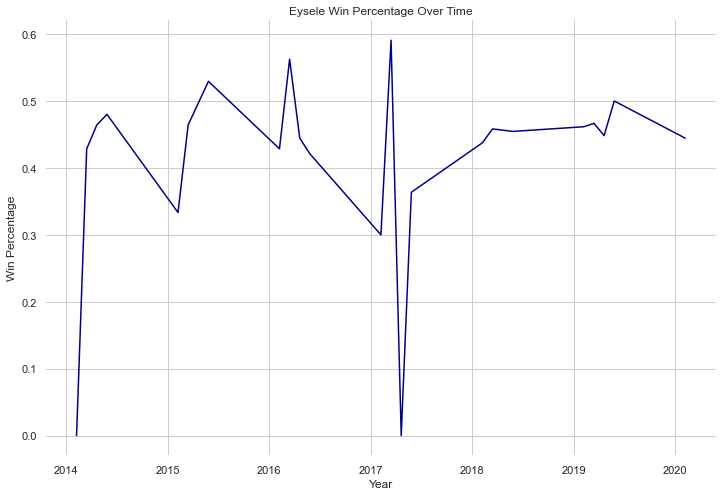

In [71]:
totalsEysele = [int(a) + int(b) for a, b in zip(countWinsEysele, countLossesEysele)]

winPercentEysele = [int(c) / int(d) for c, d in zip(countWinsEysele, totalsEysele)]

fig = sns.lineplot(x = yearWinsEysele, y = winPercentEysele, color = "darkblue")
fig.set(title = "Eysele Win Percentage Over Time", xlabel="Year", ylabel="Win Percentage")
sns.despine(left=True, bottom=True)

and how Tristan has ranked over time:

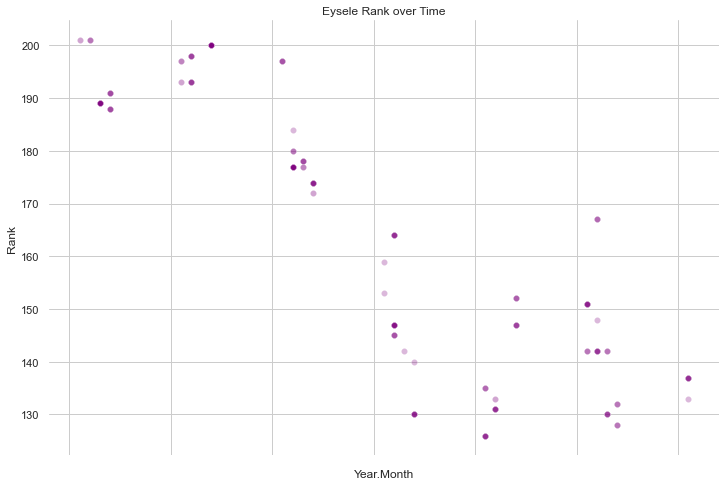

In [72]:
# rank over time

fig = sns.scatterplot(data = eysele, x = "year_month", y="Rank", color = "purple",  alpha=0.1)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set(title = "Eysele Rank over Time", xlabel="Year.Month", ylabel="Rank")

sns.despine(left=True, bottom=True)

From the graph above, it looks like Tristan has fluctuated quite a bit in rank over the years, from around 200 all the way down to around 130, and it looks like a steady improvement.

## Comparing `Tristan Eysele` and `Mohamed El Shorbagy`

### Comparing Win Percent between Tristan Eyesele and El Shorbagy

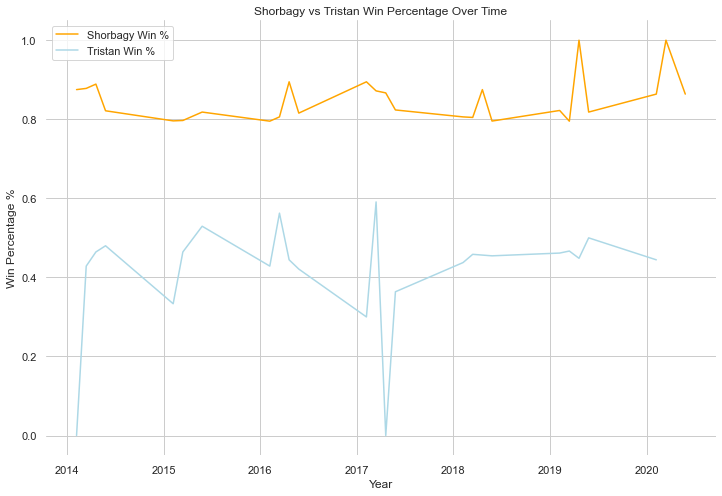

In [74]:
fig = sns.lineplot(x = yearWinsShorbagy, y = winPercentShorbagy, color = "orange", legend='brief', label="Shorbagy Win %")
fig = sns.lineplot(x = yearWinsEysele, y = winPercentEysele, color = "lightblue", legend='brief', label="Tristan Win %")
fig.set(title = "Shorbagy vs Tristan Win Percentage Over Time", xlabel="Year", ylabel="Win Percentage %")
sns.despine(left=True, bottom=True)

sns.despine(left=True, bottom=True)

As expected, there is a stark difference in level between the win percentages of both players, since both have stark differences in rank.

### General win/loss record across all games

Those average game scores sure seem similar. Let's see what their record looks like:

Shorbagy Win % Across All Games:
0.83


Eysele Win % Across All Games:
0.5283842794759825


[Text(0, 0.5, 'Number of Games'),
 Text(0.5, 0, 'Win/Loss'),
 Text(0.5, 1.0, 'Eysele vs. Shorbagy Record')]

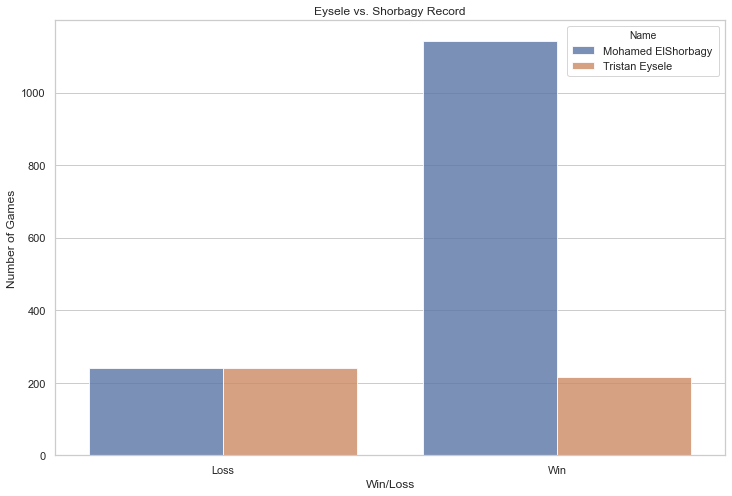

In [75]:
both = shorbagy.append(eysele)

shorbagyPercent = round(shorbagy["Win_Loss"].value_counts()[0] / len(shorbagy),2)
print("Shorbagy Win % Across All Games:")
print(shorbagyPercent)

print("\n")

eyselePercent = eysele["Win_Loss"].value_counts()[0] / len(eysele)
print("Eysele Win % Across All Games:")
print(eyselePercent)

fig = sns.countplot(data = both, x = "Win_Loss", hue = "Name", alpha=0.8)
fig.set_xticklabels(fig.get_xticklabels(), rotation=0)
fig.set(title = "Eysele vs. Shorbagy Record", xlabel="Win/Loss", ylabel="Number of Games")


## `Overall` Analysis: Here we analyze groups of players based on their ranking

Wow  - it's pretty clear why Shorbagy is our champion. 

Playing Squash sure looks grueling. Let's see if there are seasonal participation trends that separate the high ranking players from the lower rankings ones.

### Number of games played by each player belong to the 3 different ranking groups (Top 20, Mid Rank, Low Rank) in 2019

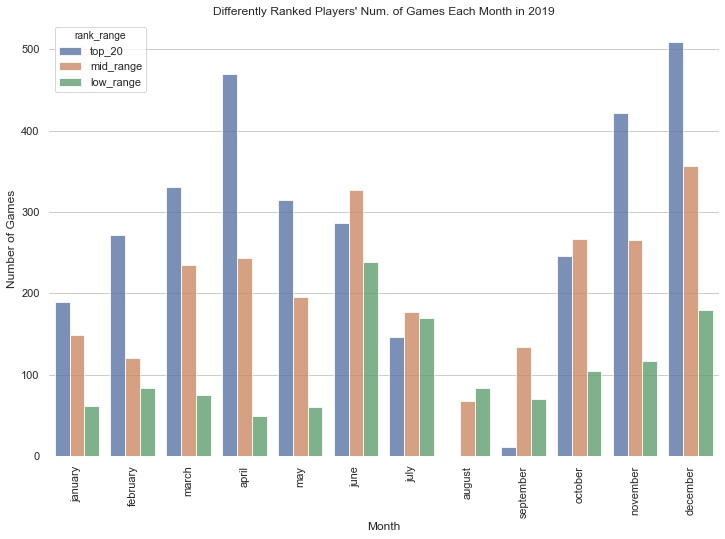

In [76]:
rank_condition_list = [
    ((data['Rank']<=20) & (data['Year']==2019)) ,
    ((data['Rank']<=100) & (data['Rank']>=80) & (data['Year']==2019)),
    ((data['Rank']<=200) & (data['Rank']>=180) & (data['Year']==2019))]
rank_choice_list = ['top_20', 'mid_range', 'low_range']
data['rank_range'] = np.select(rank_condition_list, rank_choice_list, default='Not Specified')

age_condition_list = [
    ((data['Age_Then']<=20) & (data['Year']==2019)) ,
    ((data['Age_Then']<=30) & (data['Age_Then']>20) & (data['Year']==2019)),
    ((data['Age_Then']<=45) & (data['Age_Then']>30) & (data['Year']==2019))]
age_choice_list = ['teenager', 'young_adult', 'middle_aged']
data['age_range'] = np.select(age_condition_list, age_choice_list, default='Not Specified')

rank_type_data = data[data.rank_range != "Not Specified"]

# sorting the months
rank_type_data["Month"] = pd.Categorical(rank_type_data['Month'], ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december'])
rank_type_data.sort_values("Month")

fig = sns.countplot(data = rank_type_data, x="Month", hue = "rank_range", alpha=0.8)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set(title = "Differently Ranked Players' Num. of Games Each Month in 2019", xlabel="Month", ylabel="Number of Games")
sns.despine(left=True, bottom=True)

From the graph above, it looks like:
<br><br>
1) Low range players seem to participate in games most in the month of june and second most in december while, top 20 range participate the most in the month of december and second most in april.
<br><br>
2) Mid range players seem to participate in games more in december, and second most during the month of june. This overlaps with both top 20 and low range player patterns, which is indicative that there is a pattern/effect on the seasonal partcipation based on player ranking, with top players playing more often during winter months, and the lower scoring ones participating more in summer.
<br><br>

In general it looks like good players play a lot more games. That makes sense - the higher ranked you are the more potential there is to make a lot of money and the more tournaments you are invited to. 

### Let's now see if there is an effect by Age Group and Rank Group on the number of games played in 2019

[Text(0, 0.5, 'Number of Games'),
 Text(0.5, 0, 'Age Group'),
 Text(0.5, 1.0, ' Num. of Games Played Per Rank Group Per Age Group in 2019')]

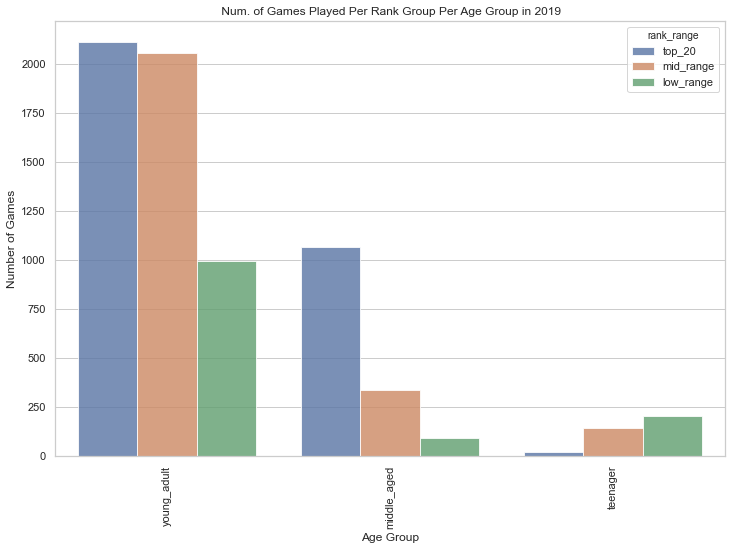

In [79]:
fig = sns.countplot(data = rank_type_data, x="age_range", hue = "rank_range", alpha=0.8)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set(title = " Num. of Games Played Per Rank Group Per Age Group in 2019", xlabel="Age Group", ylabel="Number of Games")

From the graph above, it looks like:
<br><br>
1) Generally, young adult squash players play the most amount of games, followed by middle-aged players, and least of all teenage players.
<br><br>
2) Because of this, naturally, young adult squash players had the highest number of games played regardless of their rank range.
<br><br>
3) In both top 20 and midrange ranked players, middle aged players played less games than young adults, but more games than teenage players.
<br><br>
4) In low range players, teenage players seem to be more active in playing games than middle aged players.
    

Along with all the things we mentioned above it looks like there are a lot of differences between Squash players of different age and rank.

## Additional Findings

Along with all the things we mentioned above it looks like there are a lot of differences between Squash players of different age and rank.
<br><br>
1) Low range players seem to participate in games most in the month of june and second most in december while, top 20 range participate the most in the month of december and second most in april.
<br><br>
2) Mid range players seem to participate in games more in december, and second most during the month of june. This overlaps with both top 20 and low range player patterns, which is indicative that there is a pattern/effect on the seasonal partcipation based on player ranking, with top players playing more often during winter months, and the lower scoring ones participating more in summer.
<br><br>
3) Generally, young adult squash players play the most amount of games, followed by middle-aged players, and least of all teenage players.
<br><br>
4) Because of this, naturally, young adult squash players had the highest number of games played regardless of their rank range.
<br><br>
5) In both top 20 and midrange ranked players, middle aged players played less games than young adults, but more games than teenage players.
<br><br>
6) In low range players, teenage players seem to be more active in playing games than middle aged players.

#  Part 3: Machine Learning Modeling

In [80]:
data.Win_Loss.value_counts()

Win     55615
Loss    42700
Name: Win_Loss, dtype: int64

We can see that the class distribution of Wins and Losses are relatively balanced hence there is not a lot of class imbalance

### Feature & Target Distribution

First we group the data by `player`

In [81]:
data_groups_by_player = data.groupby("Name")
group_sizes = data_groups_by_player.size()

In [82]:
y = list(range(0,340))
x = group_sizes.tolist()

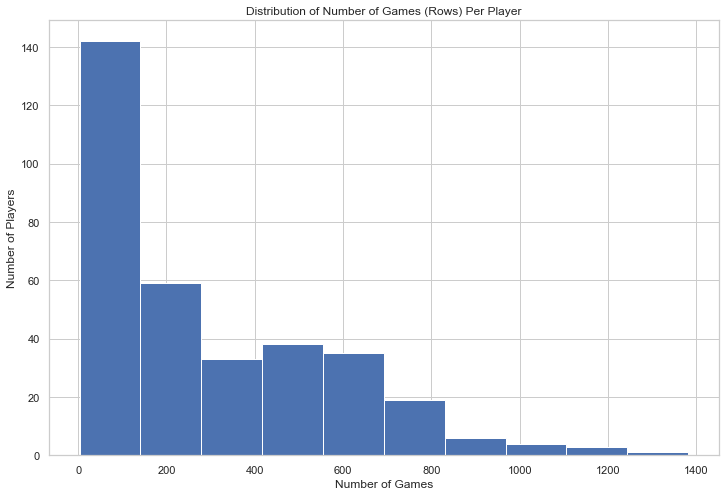

In [84]:
# Number Of Games each player has played
plt.hist(group_sizes.tolist())
plt.xlabel("Number of Games")
plt.ylabel("Number of Players")
plt.title("Distribution of Number of Games (Rows) Per Player")
plt.show()

So we have 340 unique players and the distributed in the way above. We have a min number of rows with 3 and maximum of 1382. The mean number of rows per player is 289 with a SD of 274. The distribution of the number of rows (number of games played) is shown below.

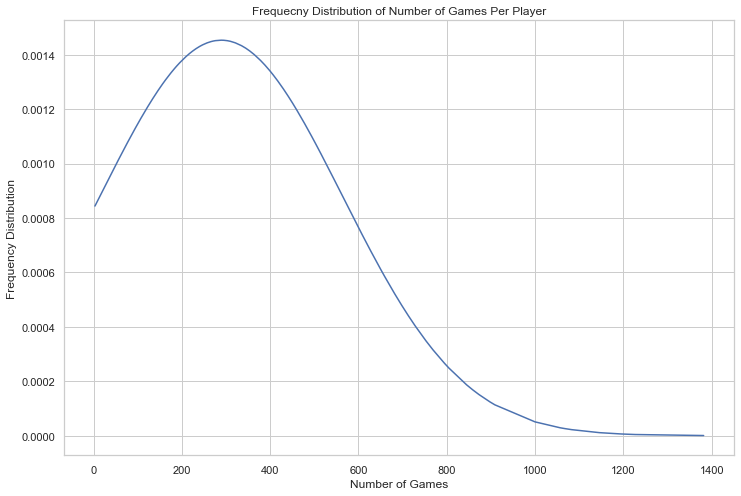

In [85]:
h = sorted(x)  
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit)
plt.xlabel("Number of Games")
plt.ylabel("Frequency Distribution")
plt.title("Frequecny Distribution of Number of Games Per Player")
plt.show() 

### Feature Extraction

List of Performance Features:

These are all the relevant features we could think of to create from this data. We wanted to cover the various categories of performance features related to `points`, `games` & `matches` along with individual player features such as `rank` and `age`

`For the Player` (All Features are Cumulative according to month_data (rows ordered))

1. Total Points Scored 
2. Total Points Conceded
3. Total Games Won
4. Total Games Played
5. Game Win Percentage (Needs Total Games Played)
6. Total Matches Won
7. Total Matches Played
8. Match Win Percentage (Needs Total Match Played)
9. Age 
10. Rank

`For the Opponent` 
1. Age
2. Current Rank 

`Circumstantial Features` 
1. Round of Tournament (Dummy Variable Format)

`Total Features = 13`

Function to extract relevant features

In [86]:
# Total Points Scored
def total_points_scored(df):
    total_points = 0
    for score in df.Score.tolist():
        if score != ' -':
            total_points += int(score.strip().split("-")[0])
    return total_points

# Total Points Conceded
def total_points_conceded(df):
    total_points = 0
    for score in df.Score.tolist():
        if score != ' -':
            total_points += int(score.strip().split("-")[1])
    return total_points

# Total Game Won
def total_games_won(df):
    games_won = 0
    for score in df.Score.tolist():
        if score != ' -':
            if int(score.strip().split("-")[0]) > int(score.strip().split("-")[1]):
                games_won += 1
    return int(games_won)

# Match Game Percentage
def game_win_percentage(df):
    return float(total_games_won(df) / df.shape[0])
    
# Total Match Won
def total_match_won(df):
    win_x_player_df = df[df.Win_Loss == "Win"]
    wins_dict = dict(collections.Counter(win_x_player_df.Game_Number.tolist()))
    if len(wins_dict) == 0:
        return 0
    else:
        return wins_dict[1]

# Match Win Percentage
def match_win_percentage(df):
    num_wins = total_match_won(df)
    total_match_dict = dict(collections.Counter(df.Game_Number.tolist()))
    if len(total_match_dict) == 0:
        return 0
    else:
        total_match = total_match_dict[1]
    win_perc = float(num_wins/total_match)
    return win_perc

# Number of Matches Played 
def num_match_played(df):
    total_match_dict = dict(collections.Counter(df.Game_Number.tolist()))
    if len(total_match_dict) == 0:
        return 0
    else:
        return total_match_dict[1]

Storing features for each player in dictionary format

In [87]:
all_players_performance_features_dict = {}
for i in range(len(list(data_groups_by_player))):
    x_player_df = list(data_groups_by_player)[i][1]
    x_player_df = x_player_df.reset_index()
    x_player_df = x_player_df.drop(["index"], axis=1)
    temp_feats = {}
    temp_feats["total_points_scored"] = total_points_scored(x_player_df)
    temp_feats["total_points_conceded"] = total_points_conceded(x_player_df)
    temp_feats["total_games_won"] = total_games_won(x_player_df)
    temp_feats["game_win_percentage"] = game_win_percentage(x_player_df)
    temp_feats["total_match_won"] = total_match_won(x_player_df)
    temp_feats["match_win_percentage"] = match_win_percentage(x_player_df)
    temp_feats["match_played"] = num_match_played(x_player_df)
    temp_feats["games_played"] = x_player_df.shape[0]
    temp_feats["year_born"] = int(x_player_df.DOB.tolist()[0].split(",")[1].strip())
    all_players_performance_features_dict[str(list(data_groups_by_player)[i][0].strip())] = temp_feats

This was a problem we encountered with this dataset. The opponent names are given (as they are on the website) in the format 'First Name Initial _ Last Name'. This is a different format than the Name column of the data which gives the full name hence we need to make separate dictionary that has the opponent name format for each player

The following function converts the full name in the opponent name format

In [88]:
def make_opponent_key(old_name):
    new_name = old_name[0] + ". " + old_name.split()[-1]
    return new_name

In [89]:
opponent_name_all_players_performance_features_dict = all_players_performance_features_dict.copy()

# Special Duplicated Initials and Last Name cases
opponent_name_all_players_performance_features_dict.pop("Vini Rodrigues")
opponent_name_all_players_performance_features_dict.pop("Robertino Pezzota")
opponent_name_all_players_performance_features_dict.pop("Marwan ElShorbagy")

for k in opponent_name_all_players_performance_features_dict.keys():
    opponent_name_all_players_performance_features_dict[make_opponent_key(k)] = opponent_name_all_players_performance_features_dict.pop(k)
    opponent_name_all_players_performance_features_dict[make_opponent_key(k)]["org_name"] = k
    
# Special Cases
opponent_name_all_players_performance_features_dict[make_opponent_key('Abdulrahman Al-Malki')] = opponent_name_all_players_performance_features_dict.pop('Abdulrahman Al-Malki')
opponent_name_all_players_performance_features_dict[make_opponent_key(k)]["Abdulrahman Al-Malki"] = 'Abdulrahman Al-Malki'
opponent_name_all_players_performance_features_dict[make_opponent_key('Abhay Singh')] = opponent_name_all_players_performance_features_dict.pop('Abhay Singh')
opponent_name_all_players_performance_features_dict[make_opponent_key(k)]["Abhay Singh"] = k


Making year_month combination and adding the rank of each player in each month_year to a dictionary

In [90]:
data['Year_str'] = data['Year'].astype(str)
data["year_month_str"] = data["Year_str"]+data["Month"]
player_ranking_dictionaries = {}

for p_name in list(set(data.Name.tolist())):
    d2 = data[data.Name == p_name]
    d2_year_month_group = list(d2.groupby("year_month_str"))
    temp_dict = {}
    for i in range(len(list(d2.groupby("year_month_str")))):
        temp_dict[d2_year_month_group[i][0]] = d2_year_month_group[i][1].Rank.tolist()[0]
    player_ranking_dictionaries[p_name.strip()] = temp_dict
        

In [91]:
data_sorted_by_player = data.sort_values(by=['Name', 'Year', 'Month'])
data_sorted_by_player = data_sorted_by_player.reset_index()

First we make the features for each row so that we can later make them cumalative

In [92]:
##### MAKING MATCH PLAYED AND MATCH WON

match_won = []
match_played = []
for i in range(len(data_sorted_by_player.Win_Loss)):
    if i > 0:
        if data_sorted_by_player.iloc[i,]["Opponent"] != data_sorted_by_player.iloc[i-1,]["Opponent"]:
            match_played.append(1)
        else:
            match_played.append(0)
    if i == 0:
        match_played.append(1)
        
    if data_sorted_by_player.iloc[i,]["Round"] == "Round 1":
        if data_sorted_by_player.iloc[i,]["Win_Loss"] == "Win":
            if i > 0 and data_sorted_by_player.iloc[i-1,]["Round"] != "Round 1":
                match_won.append(1)
            elif i == 0:
                match_won.append(1)
            else:
                match_won.append(0)
        else:
            match_won.append(0)
    else:
        match_won.append(0)

data_sorted_by_player["match_won"] = match_won
data_sorted_by_player["match_played"] = match_played

print(0)

0


In [93]:
##### MAKING POINTS SCORED AND CONCEDED AND GAMES PLAYED AND GAMES WON 

points_conceded = []
games_played = []
game_won = []
points_scored = []
for s in data_sorted_by_player.Score:
    games_played.append(1)
    if s != ' -':
        points_scored.append(int(s.split("-")[0]))
        points_conceded.append(int(s.split("-")[1]))
        if int(s.split("-")[0]) > int(s.split("-")[1]):
            game_won.append(1)
        else:
            game_won.append(0)
            
    else:
        game_won.append(0)
        points_scored.append(0)
        points_conceded.append(0)
        
data_sorted_by_player["games_won"] = game_won
data_sorted_by_player["points_conceded"] = points_conceded
data_sorted_by_player["points_scored"] = points_scored
data_sorted_by_player["games_played"] = games_played

print(0)

0


We take the existing features and make them cumulative according to rows using the pandas cumsum() function

In [94]:
initial_data_frame = list(data_sorted_by_player.groupby(["Name"]))[0][1]

initial_data_frame["cumal_games_won"] = initial_data_frame.games_won.cumsum()
initial_data_frame["cumal_points_conceded"] = initial_data_frame.points_conceded.cumsum()
initial_data_frame["cumal_points_scored"] = initial_data_frame.points_scored.cumsum()
initial_data_frame["cumal_games_played"] = initial_data_frame.games_played.cumsum()
initial_data_frame["cumal_match_won"] = initial_data_frame.match_won.cumsum()
initial_data_frame["cumal_match_played"] = initial_data_frame.match_played.cumsum()

initial_data_frame = initial_data_frame.drop(["games_won",
                                            "points_conceded",
                                            "points_scored",
                                            "games_played",
                                            "match_won",
                                            "match_played",
                                             "MonthNum",
                                             "Tournament", "score1", "score2", "totalScore"], axis=1)

for j in range(len(list(data_sorted_by_player.groupby(["Name"])))):
    initial_data_frame1 = list(data_sorted_by_player.groupby(["Name"]))[j][1]
    initial_data_frame1["cumal_games_won"] = initial_data_frame1.games_won.cumsum()
    initial_data_frame1["cumal_points_conceded"] = initial_data_frame1.points_conceded.cumsum()
    initial_data_frame1["cumal_points_scored"] = initial_data_frame1.points_scored.cumsum()
    initial_data_frame1["cumal_games_played"] = initial_data_frame1.games_played.cumsum()
    initial_data_frame1["cumal_match_won"] = initial_data_frame1.match_won.cumsum()
    initial_data_frame1["cumal_match_played"] = initial_data_frame1.match_played.cumsum()

    initial_data_frame1 = initial_data_frame1.drop(["games_won",
                                                "points_conceded",
                                                "points_scored",
                                                "games_played",
                                                "match_won",
                                                "match_played",
                                                 "MonthNum",
                                                 "Tournament", "score1", "score2", "totalScore"], axis=1)
    initial_data_frame = initial_data_frame.append(initial_data_frame1, ignore_index = True) 

final_data = initial_data_frame

Adding the cumalative win percentage features for games and matches

In [95]:
final_data = final_data.sort_values(by=['index'])
final_data = final_data.reset_index()
final_data = final_data.drop(['level_0', "index"], axis=1)
final_data["cumal_game_win_perc"] = final_data["cumal_games_won"] / final_data["cumal_games_played"]
final_data["cumal_match_win_perc"] = final_data["cumal_match_won"] / final_data["cumal_match_played"]


In [138]:
### Dropping unneeded columns
final_data2 = final_data.drop(["Month", "DOB", "Year_str", "year_month", "Score"], axis=1)

Since we do not need the information regarding all the games in a match (we only need the match outcome because that is what we are predicting. We will only keep 1 row per match now

In [139]:
final_data3 = pd.DataFrame(columns=list(final_data2.columns))

for i in range(final_data2.shape[0]):
    if i > 0:
        if (final_data2.iloc[i,]["Name"] == final_data2.iloc[i-1,]["Name"]):
            if final_data2.iloc[i,]["cumal_match_played"] != final_data2.iloc[i-1,]["cumal_match_played"]:
                final_data3 = final_data3.append(final_data2.iloc[i,],ignore_index=True)
        else:
            final_data3 = final_data3.append(final_data2.iloc[i,],ignore_index=True)

Getting features from dictionaries for opponents

In [98]:
opp_age = []
opp_rank = []
for i in range(final_data3.shape[0]):    
    opp_name = final_data3.iloc[i,]["Opponent"]
    year_month = final_data3.iloc[i,]["year_month_str"]
    try:
        opp_full_name = opponent_name_all_players_performance_features_dict[opp_name]["org_name"]
        opp_rank.append(player_ranking_dictionaries[opp_full_name][year_month])
        t_age =  int(final_data3.iloc[i,]["Year"]) - int(opponent_name_all_players_performance_features_dict[opp_name]["year_born"])
        opp_age.append(t_age)
    except KeyError:
        opp_rank.append(np.nan)
        opp_age.append(np.nan)
final_data3["opp_age"] = opp_age
final_data3["opp_rank"] = opp_rank

final_data3.opp_age = final_data3.opp_age.fillna(int(np.mean(final_data3.opp_age)))
final_data3.opp_rank = final_data3.opp_age.fillna(201)

final_data3.dropna(inplace=True)

In [100]:
### FINAL FORMATTING OF DATA INTO FEATURE FORMAT
final_data_4 = final_data3.drop(["Year",
                               "Name",
                               "Opponent",
                               "Game_Number", "year_month_str", "Torn_Class"], axis=1)

final_data_4 = final_data_4.rename(columns={'Rank': 'p1_rank',
                                          "Win_Loss" : "Target",
                                          "Age_Then" : "p1_age",
                                          "cumal_games_won" : "p1_cumal_games_won",
                                          "cumal_points_conceded" : "p1_cumal_points_conceded",
                                          "cumal_points_scored" : "p1_cumal_points_scored",
                                          "cumal_games_played" : "cumal_games_played",
                                          "cumal_match_won" : "p1_cumal_match_won",
                                          "cumal_match_played" : "p1_cumal_match_played",
                                          "cumal_game_win_perc" : "p1_cumal_game_win_perc",
                                          "cumal_match_win_perc" : "p1_cumal_match_win_perc",})

Making features for Round in Dummy Variable Format

In [101]:
round_dummy_data_set = pd.get_dummies(final_data_4.Round)

final_features = pd.concat([final_data_4, round_dummy_data_set], axis=1, sort=False)
final_features.drop(["Round"], axis=1, inplace=True)
final_features.head()

,p1_rank,Target,p1_age,rank_range,age_range,p1_cumal_games_won,p1_cumal_points_conceded,p1_cumal_points_scored,cumal_games_played,p1_cumal_match_won,...,p1_cumal_game_win_perc,p1_cumal_match_win_perc,opp_age,opp_rank,Final,Quarter final,Round 1,Round 2,Round 3,Semi final
0,1,Win,32,Not Specified,Not Specified,4,21,44,4,0,...,1.000000,0.0,23.0,23.0,0,0,0,0,0,1
1,1,Win,32,Not Specified,Not Specified,6,58,78,8,0,...,0.750000,0.0,27.0,27.0,0,1,0,0,0,0
2,1,Win,32,Not Specified,Not Specified,10,83,122,12,0,...,0.833333,0.0,23.0,23.0,0,0,0,1,0,0
3,1,Win,32,Not Specified,Not Specified,13,101,155,15,1,...,0.866667,0.2,25.0,25.0,0,0,1,0,0,0
4,2,Win,34,Not Specified,Not Specified,1,5,11,1,0,...,1.000000,0.0,31.0,31.0,1,0,0,0,0,0


In [102]:
def binarize_target(s):
    return int(s=="Win")

final_features['Target'] = final_features['Target'].apply(binarize_target)


In [109]:
final_features.drop(["rank_range", "age_range"], axis=1, inplace=True)
final_features.to_csv("final_features.csv", encoding="utf-8")

## MODEL TESTING

We will choose 3 models that encompass the 3 approaches: Bagging (Random Forests), Boosting (AdaBoost) & Linear (Logistic Regression)

Helper funtions for testing and accuracy

In [110]:
def percer(l):
    for i in range(len(l)):
        l[i] = l[i]*100
    return l

def metric_scores(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1_score

<h2 style='color:#295ccc'> Model 1: Bagging using Random Forests </h2>

In [112]:
# Load Data
final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
final_features.drop(["Unnamed: 0",], axis=1, inplace=True)

In [113]:
final_data = final_features.loc[:, final_features.columns != 'Target']
final_target = final_features.loc[:, final_features.columns == 'Target']
X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)

parameters_grid = {'n_estimators': [1, 100, 250, 500],
                    'max_depth': [1, 5, 10]}

# Using GridSearch to find best parameter combination
estimator = ms.GridSearchCV(RandomForestClassifier(), param_grid=parameters_grid)

estimator.fit(X_train, Y_train)

print('Best estimator: {}'.format(estimator.best_estimator_))
print('\nBest number of base models: {}'.format(estimator.best_params_['n_estimators']))

Best estimator: RandomForestClassifier(max_depth=10, n_estimators=500)

Best number of base models: 500


### Original Features

To bgein with we keep all the features that we have created and begin our analysis on those using RandomForests

In [114]:
final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
final_features.drop(["Unnamed: 0"], axis=1, inplace=True)

final_data = final_features.loc[:, final_features.columns != 'Target']
final_target = final_features.loc[:, final_features.columns == 'Target']
X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)

feature_list = list(X_train.columns)

# We choose 500 estimators & depth as 10 as per the GridSearchCV results
estimator = RandomForestClassifier(max_depth=10, n_estimators=500)
estimator.fit(X_train, Y_train)
Y_pred = estimator.predict(X_test)
rf_cm = confusion_matrix(Y_test, Y_pred)
rf_precision, rf_recall, rf_f1 = metric_scores(rf_cm)
print("\t\t\t\t SCORES \n")
print("F1: %f" %rf_f1)
print("Precision: %f" %rf_precision)
print("Recall: %f" %rf_recall)

				 SCORES 

F1: 0.739458
Precision: 0.663439
Recall: 0.835151


				HEAT MAP FOR RANDOM FORESTS (Tuned With GridSearch)



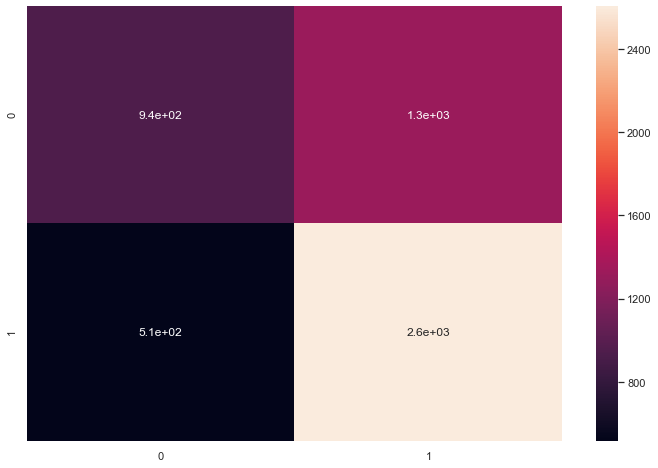

In [115]:
print("\t\t\t\tHEAT MAP FOR RANDOM FORESTS (Tuned With GridSearch)\n")
sns.heatmap(rf_cm, annot=True)

In [116]:
# Get numerical feature importances
rf = estimator
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: p1_cumal_game_win_perc Importance: 0.19
Variable: opp_age              Importance: 0.16
Variable: opp_rank             Importance: 0.16
Variable: p1_rank              Importance: 0.15
Variable: p1_cumal_match_win_perc Importance: 0.06
Variable: p1_cumal_games_won   Importance: 0.05
Variable: p1_cumal_points_conceded Importance: 0.04
Variable: p1_cumal_points_scored Importance: 0.04
Variable: Round 1              Importance: 0.04
Variable: cumal_games_played   Importance: 0.03
Variable: p1_cumal_match_won   Importance: 0.02
Variable: p1_cumal_match_played Importance: 0.02
Variable: p1_age               Importance: 0.01
Variable: Final                Importance: 0.01
Variable: Quarter final        Importance: 0.01
Variable: Semi final           Importance: 0.01
Variable: Round 2              Importance: 0.0
Variable: Round 3              Importance: 0.0


Obviously rank of both players matters a lot but interestingly the age of the opponent only seems to matter as opposed to the age of the player. This is understandable as the effect of age may be captured in some other feature of the player (the plyaer has more features about his performance than the opponent).

Text(0.5, 1.0, 'Variable importances')

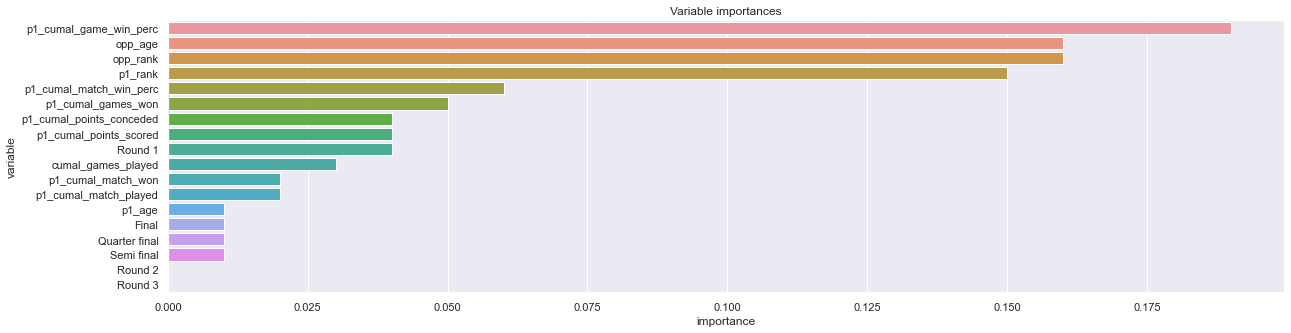

In [117]:
df_importances=pd.DataFrame()
df_importances['variable']=[val[0] for val in feature_importances]
df_importances['importance']=[val[1] for val in feature_importances]

sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(data=df_importances, x='importance', y='variable').set_title("Variable importances")

### Updated Features

We can see that there are a lot of features that are not useful. But to really fine tune our analysis we will only be keeping features with weight >= 0.10

In [118]:
final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
final_features = final_features[["p1_cumal_game_win_perc", "opp_age", "opp_rank", "p1_rank", "Target"]]
final_features.head()

,p1_cumal_game_win_perc,opp_age,opp_rank,p1_rank,Target
0,1.000000,23.0,23.0,1,1
1,0.750000,27.0,27.0,1,1
2,0.833333,23.0,23.0,1,1
3,0.866667,25.0,25.0,1,1
4,1.000000,31.0,31.0,2,1


Rerunning experiment (Keeping RF Parameters the same as before for comparison purposes) with updated features (4 Features)

				 SCORES 

F1: 0.730461
Precision: 0.680509
Recall: 0.788326
				HEAT MAP FOR RANDOM FORESTS (Tuned With GridSearch)



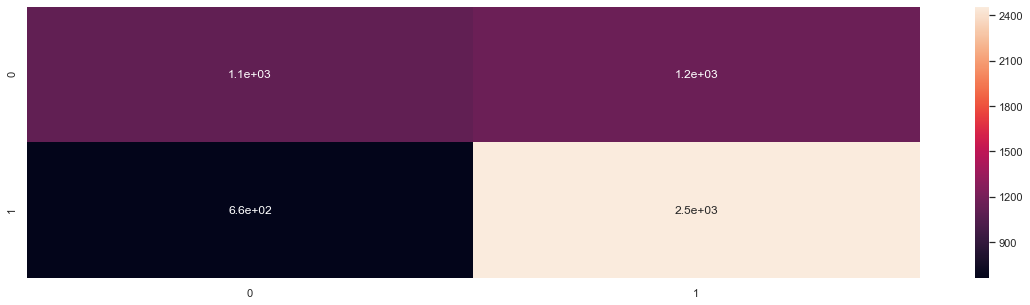

In [119]:
final_data = final_features.loc[:, final_features.columns != 'Target']
final_target = final_features.loc[:, final_features.columns == 'Target']
X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)

feature_list = list(X_train.columns)

estimator = RandomForestClassifier(max_depth=5, n_estimators=500)
estimator.fit(X_train, Y_train)
Y_pred = estimator.predict(X_test)
rf_cm = confusion_matrix(Y_test, Y_pred)
rf_precision, rf_recall, rf_f1 = metric_scores(rf_cm)
print("\t\t\t\t SCORES \n")
print("F1: %f" %rf_f1)
print("Precision: %f" %rf_precision)
print("Recall: %f" %rf_recall)

print("\t\t\t\tHEAT MAP FOR RANDOM FORESTS (Tuned With GridSearch)\n")
sns.heatmap(rf_cm, annot=True)

In [120]:
# Get numerical feature importances
rf = estimator
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: p1_cumal_game_win_perc Importance: 0.32
Variable: p1_rank              Importance: 0.28
Variable: opp_age              Importance: 0.2
Variable: opp_rank             Importance: 0.19


Feature weights slightly change in this. Game Win Percentage still remains the highest weighted feature. However, in this model P1_rank it higher ranked than the 2 other features about oppornent rank and age.

We can see that with the updated features (4 selected) the Precision score increases whereas the Recall and F1 score tend to decrease. This is acceptable since the difference is not a lot in terms of absolute value. For our task Precision matters more than the Recall because we do not want the False Positive rate to be high as that way the matches we predict to be Wins would actually have a higher certaintity of being wins.

However, for future improvements we could perform an error analysis on both sets of predictions and add more relevant features to the selected features list

<h2 style='color:#295ccc'> Model 2: Logistic Regression </h2>

We keep the Threshold at 0.5

We first want to see which features matter the most (feature weights) when using a Logistic Regression Classifier. For this feature ranking we use Recursive Feature Elimination

#### Using RFE

In [123]:
final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
final_features.drop(["Unnamed: 0"], axis=1,  inplace=True)
final_data = final_features.loc[:, final_features.columns != 'Target']
final_target = final_features.loc[:, final_features.columns == 'Target']
X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)

logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X_train, Y_train)
predictor = X_train

# Getting Feature Rankings
selector = RFE(logreg, n_features_to_select=1)
selector.fit(predictor, Y_train)

order = selector.ranking_
order
feature_ranks = []
for i in order:
    feature_ranks.append(f"{i}. {X_train.columns[i-1]}")

In [124]:
print("\t\t MOST IMPORTANT FEATURES Using Logistic Regression")
order_feats_by_weight = []
count = 1
while count < 19:
    for i in range(len(feature_ranks)):
        if int(feature_ranks[i].split(".")[0]) == count:
            print(feature_ranks[i])
            order_feats_by_weight.append(feature_ranks[i])
            count+=1
lr_feature_weights = order_feats_by_weight

		 MOST IMPORTANT FEATURES Using Logistic Regression
1. p1_rank
2. p1_age
3. p1_cumal_games_won
4. p1_cumal_points_conceded
5. p1_cumal_points_scored
6. cumal_games_played
7. p1_cumal_match_won
8. p1_cumal_match_played
9. p1_cumal_game_win_perc
10. p1_cumal_match_win_perc
11. opp_age
12. opp_rank
13. Final
14. Quarter final
15. Round 1
16. Round 2
17. Round 3
18. Semi final


In [125]:
### Using 0.5 Probability Threshold

num_feats, all_f1_scores, all_recall_scores, all_precision_scores = [], [], [], []
for i in range(1,18):
    the_cols = ["Target"]
    for j in range(i):
        the_cols.append(order_feats_by_weight[j].split(".")[1].strip())
        
    final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
    final_features.drop(["Unnamed: 0"], axis=1,  inplace=True)
    final_features = final_features[the_cols]

    final_data = final_features.loc[:, final_features.columns != 'Target']
    final_target = final_features.loc[:, final_features.columns == 'Target']
    X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)
    lr_model = LogisticRegression(random_state=0, fit_intercept=False).fit(X_train, Y_train)
    lr_model.predict_proba(X_test)
    THRESHOLD = 0.5
    preds = np.where(lr_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    cm = confusion_matrix(Y_test, preds)
    precision, recall, f1 = metric_scores(cm)
    num_feats.append(i)
    all_f1_scores.append(f1)
    all_precision_scores.append(precision)
    all_recall_scores.append(recall)

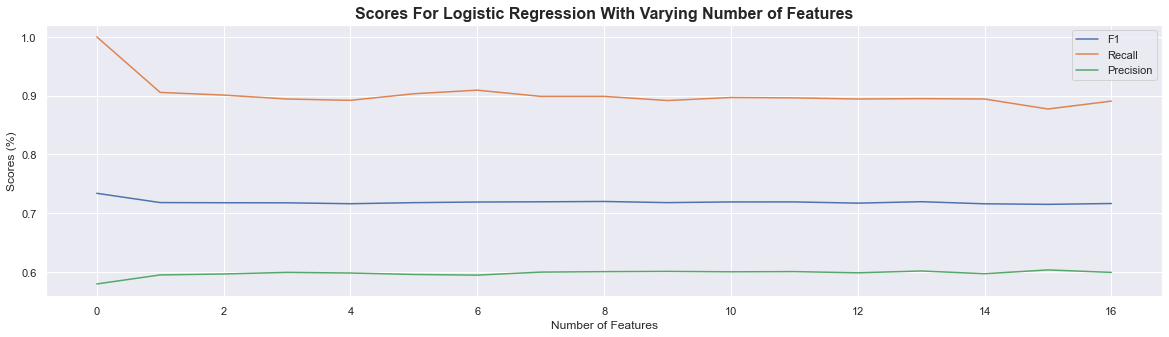

In [126]:
plt.plot(all_f1_scores, label="F1")
plt.plot(all_recall_scores, label="Recall")
plt.plot(all_precision_scores, label="Precision")
plt.legend()
plt.xlabel("Number of Features")
plt.ylabel("Scores (%)")
plt.title("Scores For Logistic Regression With Varying Number of Features", fontsize=16, fontweight='bold')
plt.show()

According to our analysis we should choose the model that uses the top 8 features as that yields the maximum F1 Score

In [127]:
n_f = all_f1_scores.index(max(all_f1_scores[1:]))

print("\t\tFeatures Used: " +str(n_f) )
for i in range(n_f):
    print(order_feats_by_weight[i])

print("\n\t\t Score With This Logistic Regression (Using Top 8 Features)\n")
print("F1:\t\t %f" %all_f1_scores[n_f])
print("Precision:\t %f" %all_precision_scores[n_f])
print("Recall:\t\t %f" %all_recall_scores[n_f])

		Features Used: 8
1. p1_rank
2. p1_age
3. p1_cumal_games_won
4. p1_cumal_points_conceded
5. p1_cumal_points_scored
6. cumal_games_played
7. p1_cumal_match_won
8. p1_cumal_match_played

		 Score With This Logistic Regression (Using Top 8 Features)

F1:		 0.719753
Precision:	 0.600257
Recall:		 0.898653


<h2 style='color:#295ccc'> Model 3: Boosting using AdaBoost </h2>

##### Using RFE

In [129]:
final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
final_features.drop(["Unnamed: 0"], axis=1,  inplace=True)
final_data = final_features.loc[:, final_features.columns != 'Target']
final_target = final_features.loc[:, final_features.columns == 'Target']
X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)

abc = AdaBoostClassifier(n_estimators=5)
predictor = X_train

selector = RFE(abc, n_features_to_select=1)
selector.fit(predictor, Y_train)

order = selector.ranking_
feature_ranks = []
for i in order:
    feature_ranks.append(f"{i}. {X_train.columns[i-1]}")

In [131]:
print("\t\t MOST IMPORTANT FEATURES Using AdaBoost")
order_feats_by_weight = []
count = 1
while count < 18:
    for i in range(len(feature_ranks)):
        if int(feature_ranks[i].split(".")[0]) == count:
            print(feature_ranks[i])
            order_feats_by_weight.append(feature_ranks[i])
            count+=1
            
abc_feature_weights = order_feats_by_weight

		 MOST IMPORTANT FEATURES Using AdaBoost
1. p1_rank
2. p1_age
3. p1_cumal_games_won
4. p1_cumal_points_conceded
5. p1_cumal_points_scored
6. cumal_games_played
7. p1_cumal_match_won
8. p1_cumal_match_played
9. p1_cumal_game_win_perc
10. p1_cumal_match_win_perc
11. opp_age
12. opp_rank
13. Final
14. Quarter final
15. Round 1
16. Round 2
17. Round 3
18. Semi final


In [132]:
num_feats, all_f1_scores, all_recall_scores, all_precision_scores = [], [], [], []
for i in range(1,18):
    the_cols = ["Target"]
    for j in range(i):
        the_cols.append(order_feats_by_weight[j].split(".")[1].strip())
        
    final_features = pd.read_csv("final_features.csv", encoding="utf-8 sig")
    final_features.drop(["Unnamed: 0"], axis=1,  inplace=True)
    final_features = final_features[the_cols]

    final_data = final_features.loc[:, final_features.columns != 'Target']
    final_target = final_features.loc[:, final_features.columns == 'Target']
    X_train, X_test, Y_train, Y_test = train_test_split(final_data , final_target, test_size = 0.2, random_state = 2)
    abc =AdaBoostClassifier(n_estimators=5)
    model = abc.fit(X_train, Y_train)
    preds = model.predict(X_test)
    cm = confusion_matrix(Y_test, preds)
    precision, recall, f1 = metric_scores(cm)
    num_feats.append(i)
    all_f1_scores.append(f1)
    all_precision_scores.append(precision)
    all_recall_scores.append(recall)

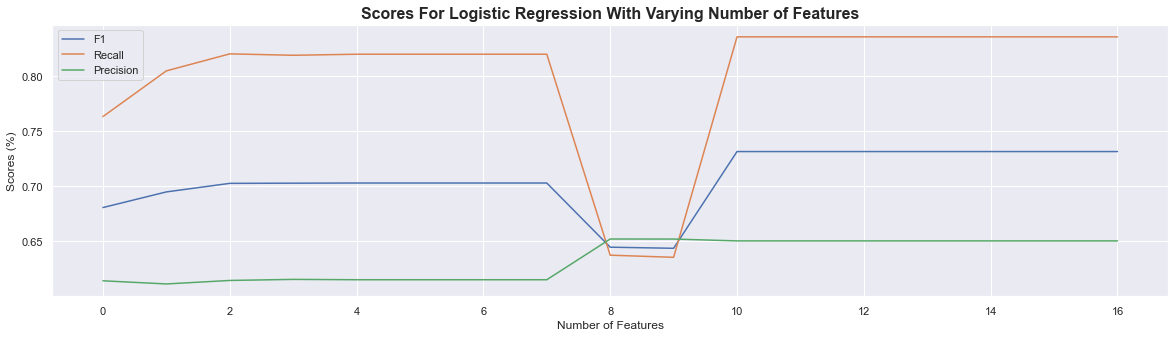

In [133]:
plt.plot(all_f1_scores, label="F1")
plt.plot(all_recall_scores, label="Recall")
plt.plot(all_precision_scores, label="Precision")
plt.legend()
plt.xlabel("Number of Features")
plt.ylabel("Scores (%)")
plt.title("Scores For Logistic Regression With Varying Number of Features", fontsize=16, fontweight='bold')
plt.show()

In [134]:
n_f = all_f1_scores.index(max(all_f1_scores[1:]))

print("\t\tFeatures Used:  " + str(n_f))
for i in range(n_f):
    print(order_feats_by_weight[i])

print("\n\t\t Score With This AdaBoost (Using Top 8 Features)\n")
print("F1:\t\t %f" %all_f1_scores[n_f])
print("Precision:\t %f" %all_precision_scores[n_f])
print("Recall:\t\t %f" %all_recall_scores[n_f])

		Features Used:  10
1. p1_rank
2. p1_age
3. p1_cumal_games_won
4. p1_cumal_points_conceded
5. p1_cumal_points_scored
6. cumal_games_played
7. p1_cumal_match_won
8. p1_cumal_match_played
9. p1_cumal_game_win_perc
10. p1_cumal_match_win_perc

		 Score With This AdaBoost (Using Top 8 Features)

F1:		 0.731358
Precision:	 0.650512
Recall:		 0.835151


### Feature Weight Comparisions

In [135]:
rf_feats = df_importances['variable'].tolist()
abc_feats = [i.split(".")[1].strip() for i in abc_feature_weights]
lr_feats = [i.split(".")[1].strip() for i in lr_feature_weights]
ranking = list(range(1,19))
rows = []
for i in range(18):
    rows.append([ranking[i], lr_feats[i], rf_feats[i],abc_feats[i]])
    
print("\t\t\t FEATURE WEIGHTS FROM EACH ALGORTIHM\n\n")
print(tabulate(rows,headers=['Ranking', 'LR', "RF", "ABC"]))

			 FEATURE WEIGHTS FROM EACH ALGORTIHM


  Ranking  LR                        RF                        ABC
---------  ------------------------  ------------------------  ------------------------
        1  p1_rank                   p1_cumal_game_win_perc    p1_rank
        2  p1_age                    opp_age                   p1_age
        3  p1_cumal_games_won        opp_rank                  p1_cumal_games_won
        4  p1_cumal_points_conceded  p1_rank                   p1_cumal_points_conceded
        5  p1_cumal_points_scored    p1_cumal_match_win_perc   p1_cumal_points_scored
        6  cumal_games_played        p1_cumal_games_won        cumal_games_played
        7  p1_cumal_match_won        p1_cumal_points_conceded  p1_cumal_match_won
        8  p1_cumal_match_played     p1_cumal_points_scored    p1_cumal_match_played
        9  p1_cumal_game_win_perc    Round 1                   p1_cumal_game_win_perc
       10  p1_cumal_match_win_perc   cumal_games_played        p1_cumal

### Results

We can see that AdaBoost and LogisticRegression give the same feature weights. In those we see that `p1_rank` and `p1_age` are the 2 most important features. This is expected as during our EDA we found that age has a strong correlation with rank which in turn (obviously) has a strong correlation with how good a player is. 

One interesting observation is that `games matter more than matches`. Remember: A squash match comprises of a best of 5 games format. Each game is 11 points each and when an individual wins 3 games they win the match. An interesting question these models answer is that it does not matter how many matches a player has won but more so it matters how many games they have won. This means that individuals that generally have matches which they have lost but which they have won a few games (1 or 2) tend to perform better. This shows us that even in matches that are lost, the degree or intensity of the defeat (by how many games someone lost) is a very important factor. This is very interesting to know as a squash player or a squash coach. We can see this games precedence over matches by the fact that LR and ABC rank `cumalative games won` as the 3rd most important feature and RF ranks `cumalaitve game win percentage` as THE most important feature.

Moreover, we can see that round does not seem to matter. This is also a fairly interesting deduction as this means that "presure" has little to do with success in squash. This can either be that the pressure of being in a final does not matter or that MOST good squash players are generally very good at keeping their nerves in control. Another insightful finding for squash players and coaches. 

We can see that the other features we created have some weight too. In their patterns we can see that winning games and matches in more important that the number of points one concedes or scores. Thus, we can conclude that the outcome of the game is most signifcant, followed by the outcome of the match, followed by the number of points in that match. This goes to show that the outcome of a game is what matters more as opposed to how close the loss or win was in terms of point difference.

## Conclusion

Though our logistic regression model has a higher recall than our random forest model, the RF model has a higher precision and f1 score. This means that while our RF model is correct 69% of the time (compared to a lower 60%), the percentage of all winning matches our logistic regression model found (86%) is higher than that of RF model (80%). Both of these are important to consider, and so we will rely on the f1 score to determine which is the better prediction model: Random Forest.
We also want to note that we predict these model scores to be higher than they currently are once we increase the amount of data we use.

The dataset we have created has a shape (98315 x 22) making it a very rich dataset. There is a lot of analysis and exploration left to be done in this dataset and these types of datasets are not very common as well. However, interest in this type of anlaysis is growing and our findings regarding trends of player rankings with things like age, seasons (months), experience and so on provides valuable knowledge to squash players and coaches. Moreover, we have shown techniques in which we can extract features from this data to provide to a ML based prediction model. More features may still be created based on these techniques or others. 

### Future Improvments

    Additional Features:
        Adding weight to features such as:
        
        1. Weighted Win Percentage (Depending on rank of opponent, higher ranked opponent more rank of win)
        
    Data Augmentation:
    
        1. Adding more data from more years.
        
        2. Adding information about training or physicality
    
    Feature Selection Based on Error Analysis:
    
        1. We can add additional features to the ones chosen on the basis of weights to improve Precision and F1 scores


#### Authors: Mariyam Amir, Spencer Burleigh, Mohammad Shahmeer Ahmad